## Στοιχεία Φοιτητή

Όνομα: Στεφανής Μιχάλης

Α.Μ.: 03400156

Ιδιότητα: Ε.ΔΕ.Μ.Μ.

e-mail: michaelstefanis@mail.ntua.gr

### Δημιουργία του Spark Session 

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[4]")\
        .appName("Data Mining Project")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

22/03/05 17:42:31 WARN Utils: Your hostname, snf-22975 resolves to a loopback address: 127.0.1.1; using 83.212.76.188 instead (on interface eth1)
22/03/05 17:42:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/05 17:42:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

### Δημιουργία του UI του PySpark (προεραιτικό) 

In [ ]:
from IPython.core.display import display, HTML
import subprocess

s = subprocess.run(["ip route get 1 | awk '{print $NF;exit}' | xargs dig +short -x"], stdout=subprocess.PIPE, shell=True)
hname = s.stdout.decode('utf-8').strip()[:-1]
display(HTML('<a href="http://' + hname  + ':4050/" target="_blank">http://' + hname + ':4050/</a>'))

# 1ο Ερώτημα: Επισκόπηση των δεδομένων

### Φόρτωση των δεδομένων στο PySpark

Τα δεδομένα του project αποτελούν συλλογή δεδομένων που αφορούν την πανδημία του Covid-19 σε όλον τον κόσμο. Στο συγκεκριμένο notebook θα ασχοληθούμε μόνο με την περίοδο Μάιο-Ιούνιο του 2021

In [5]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
import gmaps
from IPython.display import display
from math import isnan
from sklearn.ensemble import IsolationForest

In [6]:
df = spark.read.csv("owid-covid-data.csv", header=True, inferSchema=True)

In [7]:
df.select(df.date, date_format(df.date, "yyyy-mm-dd")).alias("date")

DataFrame[date: string, date_format(date, yyyy-mm-dd): string]

### 1) Ποιος είναι ο αριθμός των δειγμάτων & των χαρακτηριστικών του συνόλου δεδομένων;

In [5]:
rows = df.filter(df.date.between("2021-05-01", "2021-06-30")).count()
print('O αριθμός των δειγμάτων (γραμμών) του dataframe για την περίοδο από 2021-05-01 μέχρι 2021-06-30 είναι ίσος με: ', rows)
print('O αριθμός των χαρακτηριστικών (στηλών) του dataframe είναι ίσος με: ', len(df.columns))

O αριθμός των δειγμάτων (γραμμών) του dataframe για την περίοδο από 2021-05-01 μέχρι 2021-06-30 είναι ίσος με:  14267
O αριθμός των χαρακτηριστικών (στηλών) του dataframe είναι ίσος με:  67


### 2) Ποια είναι τα είδη των χαρακτηριστικών του συνόλου δεδομένων;

In [10]:
df.printSchema()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: double (nullable = true)
 |-- hosp_patients_per_million

### 3) Υπάρχουν μη διατεταγμένα χαρακτηριστικά και ποια είναι αυτά;


Τα μη-διατεταγμένα χαρακτηριστικά είναι τα εξής:

iso_code, continent, date, location, tests_units

Είναι δηλαδή χαρακτηριστικά των οποίων οι τιμές δεν προέρχονται από ένα διατεταγμένο σύνολο (όπως οι ακέραιοι και οι πραγματικοί αριθμοί).

### 4) Υπάρχουν απουσιάζουσες τιμές; Ταξινομήστε και παρουσιάστε, κατά φθίνουσα σειρά τα χαρακτηριστικά που έχουν απουσιάζουσες τιμές.

In [51]:
null_df = df.filter(df.date.between("2021-05-01", "2021-06-30"))

In [52]:
Dict_Null = {col:null_df.filter(df[col].isNull()).count() for col in null_df.columns}

In [53]:
sort_dict = dict(sorted(Dict_Null.items(), key=lambda item: item[1], reverse=True))

In [54]:
sort_dict

{'excess_mortality_cumulative_absolute': 13781,
 'excess_mortality_cumulative': 13781,
 'excess_mortality': 13781,
 'excess_mortality_cumulative_per_million': 13781,
 'weekly_icu_admissions': 13773,
 'weekly_icu_admissions_per_million': 13773,
 'weekly_hosp_admissions': 13314,
 'weekly_hosp_admissions_per_million': 13314,
 'total_boosters': 12840,
 'total_boosters_per_hundred': 12840,
 'icu_patients': 12220,
 'icu_patients_per_million': 12220,
 'hosp_patients': 12214,
 'hosp_patients_per_million': 12214,
 'handwashing_facilities': 8411,
 'new_vaccinations': 8179,
 'new_tests': 8144,
 'new_tests_per_thousand': 8144,
 'total_tests': 8129,
 'total_tests_per_thousand': 8129,
 'people_fully_vaccinated': 7793,
 'people_fully_vaccinated_per_hundred': 7793,
 'people_vaccinated': 7227,
 'people_vaccinated_per_hundred': 7227,
 'tests_per_case': 7181,
 'positive_rate': 7165,
 'total_vaccinations': 6951,
 'total_vaccinations_per_hundred': 6951,
 'new_tests_smoothed_per_thousand': 6830,
 'new_tests

# 2ο Ερώτημα: Προεπεξεργασία του συνόλου δεδομένων

### 1) Απουσιάζουσες τιμές

Από το προηγούμενο ερώτημα παρατηρούμε ότι υπάρχουν αρκετές απουσιάζουσες τιμές στα περισσότερα χαρακτηριστικά του dataframe. Συγκεκριμένα, στα χαρακτηριστικά 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_per_million',  'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_boosters', 'total_boosters_per_hundred', 'icu_patients', 'icu_patients_per_million',  'hosp_patients' και 'hosp_patients_per_million' το ποσοστό των απουσιάζουσων τιμών κυμαίνεται από 85.61% έως 96.59%. Πολλές από αυτές τις μεταβλητές είναι αρκετά σημαντικές για την ανάλυσή μας οπότε δεν συμφέρει να τις αφαιρέσουμε από το dataframe. Αντί αυτού θα τις αντικαταστήσουμε με μηδενικά (ή με κάποιο άλλο στατιστικό μέγεθος, όπως η μέση τιμή). Αλλά αυτό δεν θα γίνει σε αυτό το σημείο. Κάθε φορά που θα χρειαστούμε μία μεταβλητή σε ένα ερώτημα τότε θα αντιμετωπίζουμε τις απουσιάζουσες τιμές.



### 2) Έκτοπες τιμές

Το αν μία καταχώρηση σε μία στήλη του dataframe είναι έκτοπη τιμή (καθώς και η φύση της έκτοπης τιμής αυτής, π.χ. contextual/global κ.λ.π.) εξαρτάται φυσικά από την μεταβλητή αυτήν. Το αν υπάρχουν έκτοπες τιμές στο dataframe θα φανεί από την ανάλυση που θα ακολουθήσει. Αν παρατηρήσουμε αφύσικα/περίεργα μοτίβα στα διαγράμματά μας τότε αυτά θα είναι μία καλή ένδειξη ότι περιέχονται έκτοπες τιμές στο dataframe. Παρόλα αυτά μία επιλογή που υπάρχει είναι να χρησιμοποιήσουμε την κλάση IsolationForest του ScikitLearn. Η κλάση αυτή λειτουργεί σαν ένα ScikitLearn classifier. Δέχεται ένα διάνυσμα (στην προκειμένη περίπτωση μία στήλη-μεταβλητή του dataframe) και επιστρέφει ετικέτες (-1, αν πρόκειται για outlier και 1 αλλιώς).

Ας χρησιμοποιήσουμε, για παράδειγμα, την μεταβλητή excess_mortality, η οποία από τον παραπάνω πίνακα περιέχει 13781 απουσιάζουσες τιμές. Για να λειτουργήσει η συνάρτηση IsolationForest θα πρέπει να μην υπάρχουν απουσιάζουσες τιμές στα δεδομένα. Για τον λόγο αυτόν και μόνο για αυτό το παράδειγμα θα τις αντικαταστήσουμε με 0.

In [25]:
em = df.select('excess_mortality')
em = em.fillna(0).toPandas()
iso = IsolationForest()
yhat = iso.fit_predict(em)

In [29]:
print('Ο αριθμός των έκτοπων τιμών στην μεταβλητή "excess_mortality" είναι:', np.sum(yhat == -1))
print('Ο αριθμός αυτός αποτελεί το {:.2f} % των εγγραφών της μεταβλητής αυτής.'.format(np.sum(yhat == -1) / len(yhat)))

Ο αριθμός των έκτοπων τιμών στην μεταβλητή "excess_mortality" είναι: 5121
Ο αριθμός αυτός αποτελεί το 0.03 % των εγγραφών της μεταβλητής αυτής.


Παρατηρούμε ότι το ποσοστό των έκτοπων τιμών με βάση την ανάλυση της IsolationForest δεν είναι μεγάλο, είναι όμως μη-μηδενικό. Σε συνδυασμό με την γνώση ότι το μεγαλύτερο ποσοστό των εγγραφών είναι απουσιάζουσες τιμές, υπάρχει το ενδεχόμενο αυτές οι έκτοπες τιμές να είναι στην πραγματικότητα η μη-απουσιάζουσες τιμές. Η λογική αυτή μπορεί να ακολουθηθεί για όλες σχεδόν τις μεταβλητές που μας ενδιαφέρουν καθώς περιέχουν ένα τεράστιο ποσοστό απουσιάζουσων τιμών. Για τον λόγο αυτόν δεν θα αφαιρεθούν από το dataframe οι έκτοπες τιμές καθώς, σε ένα περιβάλλον γεμάτο με απουσιάζουσες τιμές, θα μπορούσαν κάλλιστα να είναι οι φυσιολογικές τιμές (μη-απουσιάζουσες). Θα δοκιμάσουμε να κάνουμε την ίδια ανάλυση έκτοπων τιμών για μία μεταβλητή με λίγες απουσιάζουσες τιμές, για παράδειγμα την total_deaths.

In [32]:
td = df.select('total_deaths')
td = td.fillna(0).toPandas()
iso = IsolationForest()
yhat = iso.fit_predict(td)
print('Ο αριθμός των έκτοπων τιμών στην μεταβλητή "total_deaths" είναι:', np.sum(yhat == -1))
print('Ο αριθμός αυτός αποτελεί το {:.2f} % των εγγραφών της μεταβλητής αυτής.'.format(np.sum(yhat == -1) / len(yhat)))

Ο αριθμός των έκτοπων τιμών στην μεταβλητή "total_deaths" είναι: 19786
Ο αριθμός αυτός αποτελεί το 0.12 % των εγγραφών της μεταβλητής αυτής.


Παρατηρούμε ότι και εδώ το ποσοστό των έκτοπων τιμών είναι μικρό. Ένας επιπλέον λόγος για τον οποίο θα έπρεπε να φοβόμαστε να αφαιρέσουμε έκτοπες τιμές είναι η έλλειψη ειδικών γνώσεων σε ό,τι αφορά το dataset. Οι έκτοπες τιμές καλό είναι να αφαιρούνται όταν και μόνο όταν είμαστε απολύτως σίγουροι ότι δεν έχουν καμία απολύτως φυσική σημασία και ότι πρόκειται για ανθρώπινο λάθος στην καταχώρηση των δεδομένων στο dataset. 

# 3ο Ερώτημα: Διερευνητική Ανάλυση Δεδομένων

### 1) Ποιες είναι οι δέκα πρώτες χώρες ως προς το ποσοστό θνησιμότητας και πως εξελίχθηκε χρονικά η σχετική κατάταξη;

Για το ερώτημα αυτό θα χρησιμοποιήσουμε την μεταβλητή 'excess_mortality'. Θα υπολογίσουμε για κάθε χώρα τον μέσο όρο της θνησιμότητας για το διάστημα που μελετάται και θα δούμε ποιες χώρες έχουν μεγαλύτερο μέσο όρο. Το ίδιο θα κάνουμε και για το αμέσως επόμενο χρονικό διάστημα (2021-07-01 έως 2021-08-31) για να ελέγξουμε κατά πόσο αλλάζει η κατάταξη.

In [53]:
mortality_per_country = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('location', 'excess_mortality')
print('Χρονικό διάστημα: 2021-05-01 έως 2021-06-31')
mortality_per_country.groupBy('location').agg(F.mean("excess_mortality")).sort(col('avg(excess_mortality)').desc()).show(10)

Χρονικό διάστημα: 2021-05-01 έως 2021-06-31
+--------+---------------------+
|location|avg(excess_mortality)|
+--------+---------------------+
|    Peru|    131.1511111111111|
|Paraguay|              128.475|
| Bolivia|    98.36000000000001|
|    Oman|                93.87|
|Colombia|    93.44444444444443|
| Ecuador|    56.74111111111111|
|   Egypt|   48.989999999999995|
| Uruguay|   46.120000000000005|
|  Brazil|   45.135000000000005|
|    Iran|    41.93000000000001|
+--------+---------------------+
only showing top 10 rows



In [54]:
mortality_per_country = df.filter(df.date.between("2021-07-01", "2021-08-31")).select('location', 'excess_mortality')
print('Χρονικό διάστημα: 2021-07-01 έως 2021-08-31')
mortality_per_country.groupBy('location').agg(F.mean("excess_mortality")).sort(col('avg(excess_mortality)').desc()).show(10)

Χρονικό διάστημα: 2021-07-01 έως 2021-08-31
+----------------+---------------------+
|        location|avg(excess_mortality)|
+----------------+---------------------+
|French Polynesia|               137.04|
|      Kazakhstan|    86.38499999999999|
|            Oman|    78.47500000000001|
|           Aruba|               71.595|
|    South Africa|   63.593333333333334|
|            Iran|    63.53666666666667|
|       Guatemala|   63.190000000000005|
|     Philippines|               55.625|
|         Bolivia|                54.46|
|          Russia|   51.480000000000004|
+----------------+---------------------+
only showing top 10 rows



Παρατηρούμε ότι η κατάταξη των χωρών με βάση την μέση υπερβάλλουσα θνησιμότητα αλλάζει με την πάροδο του χρόνου. Παρόλα αυτά και στα δύο παραπάνω χρονικά διαστήματα συμπεριλαμβάνεται το Ιράν (του οποίου η μέση υπερβάλλουσα θνησιμότητα αυξήθηκε), η Βολιβία και το Ομάν (του οποίου μειώθηκε).

### 2) Ποιες είναι οι δέκα πρώτες χώρες ως προς τα κρούσματα ανά εκατομμύριο και πως εξελίχθηκε χρονικά η σχετική κατάταξη;

Σε αυτό το ερώτημα θα χρησιμοποιήσουμε την μεταβλητή "total_cases_per_million". Αυτήν την φορά θα αθροίσουμε για κάθε χώρα την μεταβλητή αυτήν και τελικά θα βρούμε ποιες 10 χώρες έχουν μεγαλύτερο άθροισμα (δηλαδή περισσότερους συνολικούς θανάτους ανα εκατομμύριο στο χρονικό διάστημα που μελετάται).

In [55]:
cases_per_country = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('location', 'total_cases_per_million')
print('Χρονικό διάστημα: 2021-05-01 έως 2021-06-31')
cases_per_country.groupBy('location').agg(F.sum("total_cases_per_million")).sort(col('sum(total_cases_per_million)').desc()).show(10)

Χρονικό διάστημα: 2021-05-01 έως 2021-06-31
+----------+----------------------------+
|  location|sum(total_cases_per_million)|
+----------+----------------------------+
|   Andorra|        1.0775370373999998E7|
|Montenegro|                 9649725.899|
|   Czechia|                 9429216.117|
|San Marino|                 9124345.773|
|  Slovakia|                 8610696.846|
|   Bahrain|           8058905.390000002|
| Gibraltar|           7789290.904000002|
|  Slovenia|           7406702.577000002|
|Seychelles|          7039146.6970000025|
|Luxembourg|                 6691303.276|
+----------+----------------------------+
only showing top 10 rows



In [60]:
cases_per_country = df.filter(df.date.between("2021-07-01", "2021-08-31")).select('location', 'total_cases_per_million')
print('Χρονικό διάστημα: 2021-07-01 έως 2021-08-31')
cases_per_country.groupBy('location').agg(F.sum("total_cases_per_million")).sort(col('sum(total_cases_per_million)').desc()).show(10)

Χρονικό διάστημα: 2021-07-01 έως 2021-08-31
+----------+----------------------------+
|  location|sum(total_cases_per_million)|
+----------+----------------------------+
|   Andorra|        1.1697572196999997E7|
|Seychelles|        1.1405024774000002E7|
|Montenegro|        1.0279091986000001E7|
|   Czechia|                 9674392.675|
|   Bahrain|           9550642.195999999|
|San Marino|           9423992.937000005|
| Gibraltar|                 9016532.606|
|  Maldives|           8838267.535999998|
|  Slovakia|           8837685.779000001|
|  Slovenia|           7761107.180999999|
+----------+----------------------------+
only showing top 10 rows



Και στις δύο χρονικές περιόδους στην κορυφή παραμένει η Ανδόρα, ενώ παραμένουν στις 10 πρώτες χώρες το Μοντενέγκρο, η Τσεχία, το Bahrem, το Γιβραλτάρ και η Σλοβενία. Παρατηρούμε δηλαδή ότι η κατάταξη δεν αλλάζει ιδιαίτερα και όσες χώρες είχαν μεγάλο αριθμό συνολικών κρουσμάτων ανά εκατομμύριο την χρονική περίοδο 2021-05-01 έως 2021-06-31, είχαν επίσης μεγάλο αριθμό κρουσμάτων την περίοδο 2021-07-01 έως 2021-08-31.

### 3) Ποιες είναι οι δέκα πρώτες χώρες ως προς τους θανάτους ανά εκατομμύριο και πως εξελίχθηκε χρονικά η σχετική κατάταξη;

Ομοίως με το ερώτημα 2 μόνο που εδώ χρησιμοποιούμε την μεταβλητή "total_deaths_per_million".

In [57]:
deaths_per_country = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('location', 'total_deaths_per_million')
print('Χρονικό διάστημα: 2021-05-01 έως 2021-06-31')
deaths_per_country.groupBy('location').agg(F.sum("total_deaths_per_million")).sort(col('sum(total_deaths_per_million)').desc()).show(10)

Χρονικό διάστημα: 2021-05-01 έως 2021-06-31
+--------------------+-----------------------------+
|            location|sum(total_deaths_per_million)|
+--------------------+-----------------------------+
|                Peru|            333917.8469999999|
|             Hungary|           186468.00499999998|
|Bosnia and Herzeg...|           172833.48699999994|
|             Czechia|           170772.24300000007|
|           Gibraltar|           170193.84299999985|
|          San Marino|           161423.14099999995|
|     North Macedonia|           156110.38000000006|
|            Bulgaria|                   155377.355|
|          Montenegro|                   153162.722|
|            Slovakia|           137614.76499999998|
+--------------------+-----------------------------+
only showing top 10 rows



In [61]:
deaths_per_country = df.filter(df.date.between("2021-07-01", "2021-08-31")).select('location', 'total_deaths_per_million')
print('Χρονικό διάστημα: 2021-07-01 έως 2021-08-31')
deaths_per_country.groupBy('location').agg(F.sum("total_deaths_per_million")).sort(col('sum(total_deaths_per_million)').desc()).show(10)

Χρονικό διάστημα: 2021-07-01 έως 2021-08-31
+--------------------+-----------------------------+
|            location|sum(total_deaths_per_million)|
+--------------------+-----------------------------+
|                Peru|                   364449.378|
|             Hungary|            193235.7989999999|
|Bosnia and Herzeg...|           184216.19500000007|
|             Czechia|                   175505.588|
|           Gibraltar|           174438.29100000006|
|     North Macedonia|           165376.88700000002|
|            Bulgaria|           164467.84699999998|
|          San Marino|           164069.42199999993|
|          Montenegro|           162064.86200000008|
|              Brazil|           160725.96500000003|
+--------------------+-----------------------------+
only showing top 10 rows



Παρατηρούμε και εδώ ότι η κατάταξη των χωρών στις πρώτες 10 θέσεις δεν αλλάζει σχεδόν καθόλου. Η μόνη χώρα που δεν υπάρχει στο χρονικό διάστημα 2021-07-01 έως 2021-08-31 είναι η Σλοβακία, της οποία τη θέση έχει πάρει η Βραζιλία. 

### 4) Ποιο είναι το καθημερινό ποσοστό θετικότητας ανά χώρα;

Για το ερώτημα αυτό χρειαζόμαστε τις στήλες date, location & positive_rate. Πριν όμως σχεδιασθούν τα διαγράμματα θα γίνει ένα επιπλέον φιλτράρισμα στα δεδομένα. Γενικά παρατηρείται ότι αν μία χώρα αρχίζει (την 2021-05-01) με μηδενικό positive_rate, θα συνεχίζει και έτσι μέχρι το τέλος (2021-06-30). Αυτό μπορεί να φανεί δοκιμάζοντας μερικές χώρες. Για τον λόγο αυτόν θα σχεδιάσουμε εκείνες τις χώρες οι οποίες την 2021-05-01 έχουν μη-μηδενικό positive_rate.

In [62]:
positivity_rate = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'positive_rate')
positivity_rate = positivity_rate.fillna({'positive_rate':0})

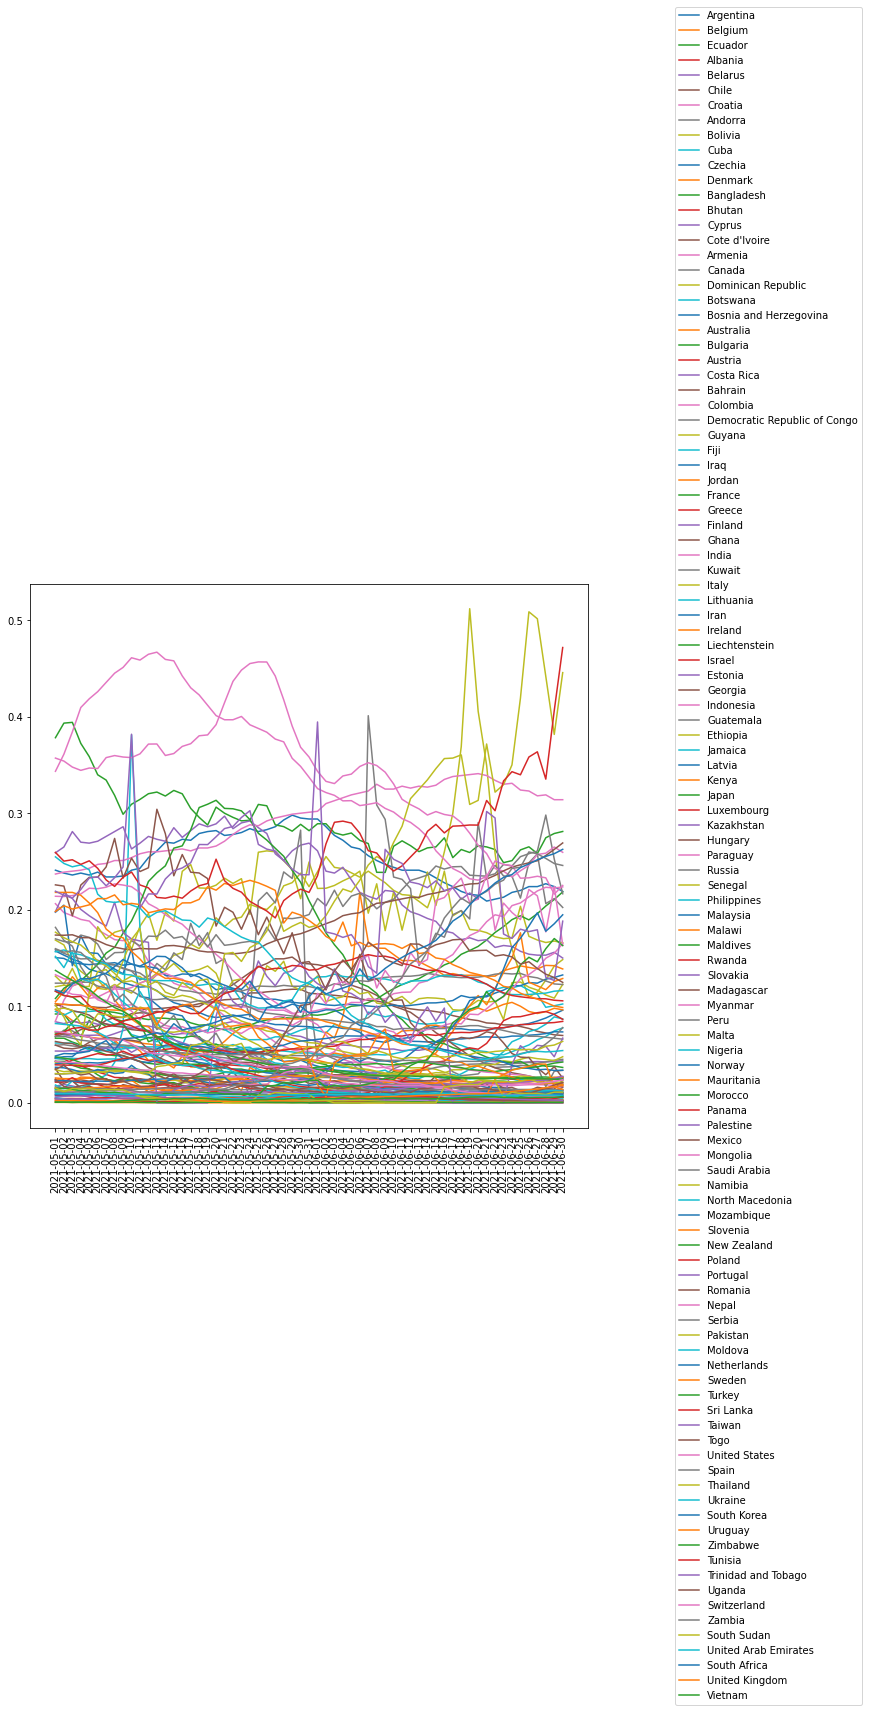

In [63]:
fig = plt.figure(figsize=(10, 10))
for country in positivity_rate.select('location').distinct().collect():
    c = positivity_rate.filter(positivity_rate.location == str(country[0])).toPandas()
    if c['positive_rate'][0] != 0:
        plt.plot(c['date'], c['positive_rate'], label = str(country[0]))

plt.xticks(rotation=90)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

Το διάγραμμα είναι πολύ περίπλοκο καθώς οι χώρες είναι πολλές και κατά πάσα πιθανότητα το matplotlb δεν έχει αρκετά χρώματα για να σχεδιάσει όλες τις καμπύλες με διαφορετικό χρώμα. Προφανώς μπορεί κανείς με την παραπάνω λογική να σχεδιάσει το καθημερινό ποσοστό θετικότητας για την χώρα ή κάποιες επιλεγμένες χώρες που τον ενδιαφέρουν.

### 5) Να σχεδιάσετε τις καμπύλες των νοσηλευόμενων ασθενών καθώς και των διασωληνωμένων σε Μονάδες Εντατικής Θεραπείας (intensive care units - ICUs)

Αρχικά σχεδιάζουμε τις χρονικές καμπύλες για τους νοσηλευόμενους ασθενείς για κάθε χώρα. Για τον σκοπό αυτόν απομονώνουμε τις στήλες date, location & hosp_patients από το dataframe. Επειδή η στήλη hosp_patients έχει πολλές απουσιάζουσες τιμές, τις αντικαθιστούμε με 0. Βάζουμε τις καμπύλες σε ένα διάγραμμα διασποράς.

In [57]:
patients = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'hosp_patients')

In [58]:
patients = patients.fillna({'hosp_patients': 0})

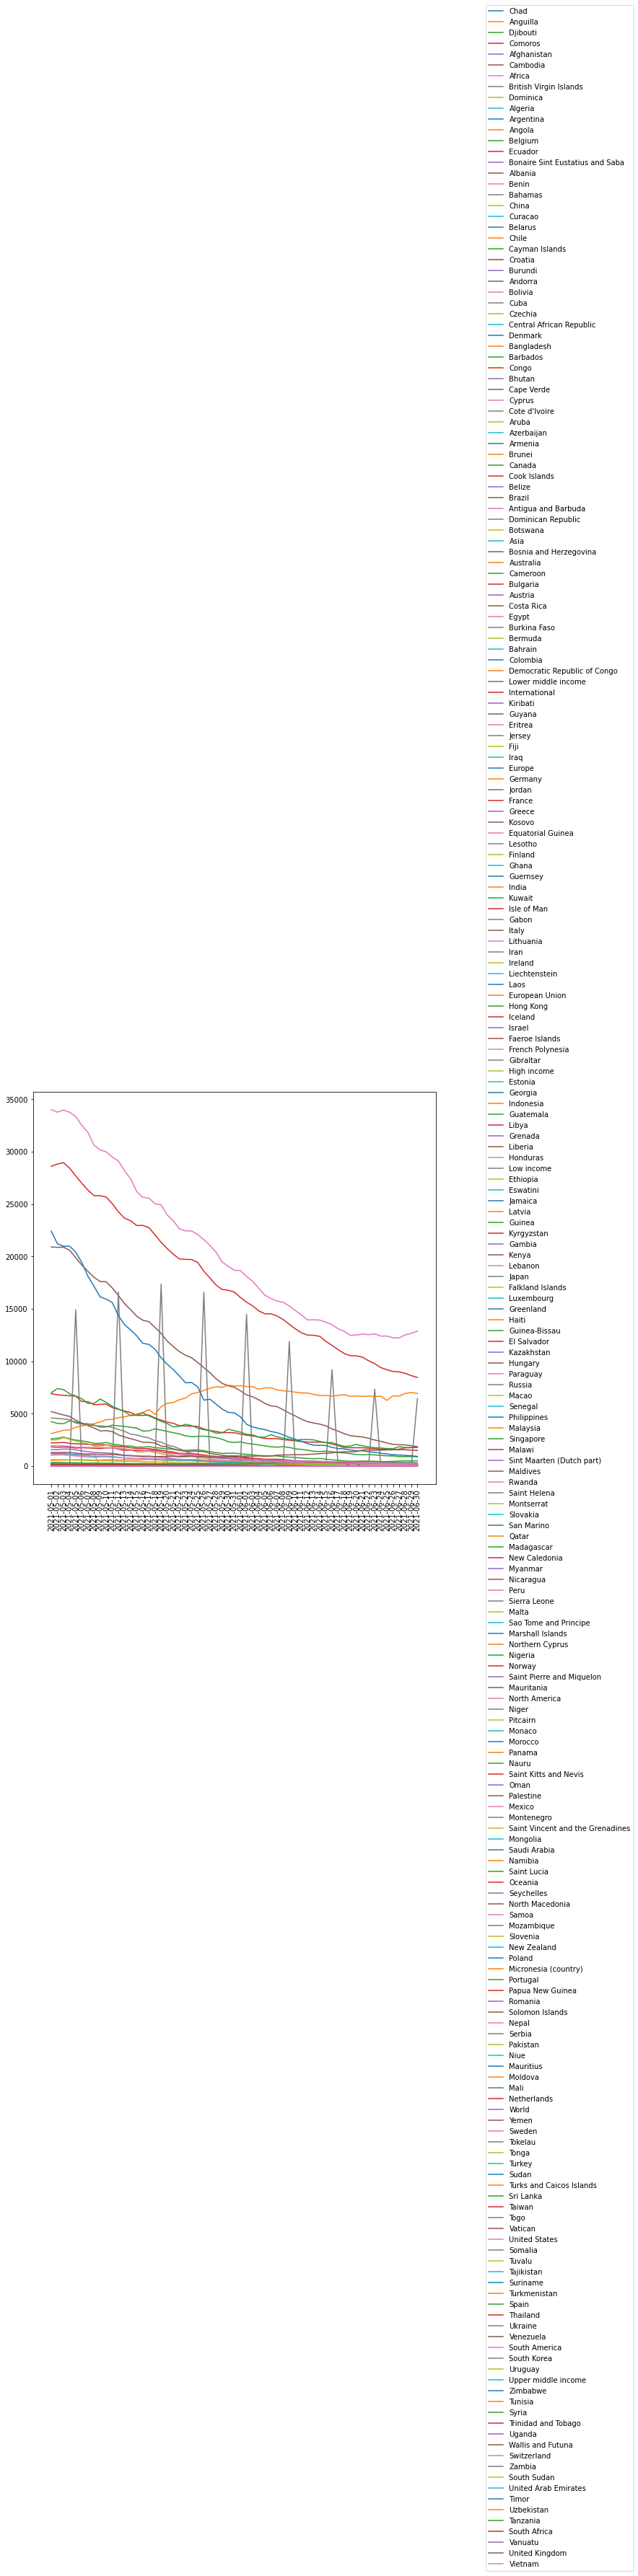

In [59]:
fig = plt.figure(figsize=(10, 10))
for country in patients.select('location').distinct().collect():
    c = patients.filter(patients.location == str(country[0])).toPandas()
    plt.plot(c['date'], c['hosp_patients'], label = str(country[0]))

plt.xticks(rotation=90)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

Το διάγραμμα είναι προφανώς χαοτικό γιατί οι χώρες είναι πάρα πολλές. Μπορεί προφανώς να γίνει ένα διάγραμμα για την κάθε χώρα ξεχωριστά ή μόνο για αυτές που μας ενδιαφέρει. Οι περισσότερες χώρες φαίνεται να έχουν μία πτωτική τάση σε ό,τι αφορά τους νοσηλευόμενους ασθενείς. Εξαίρεση αποτελεί η χώρα που αναπαριστάται από την εμφανή πορτοκαλί γραμμή που φαίνεται ότι αυξάνεται. Επίσης η καμπύλη που βγάζει μάτι είναι αυτή που έχει ένα τριγωνικό περιοδικο σχήμα. Ένας πιθανός τρόπος ερμηνείας αυτήν της καμπύλης θα ήταν να ενώσει κανείς τις κορυφές των τριγώνων αυτών και στην συνέχεια την τμηματικά συνεχή αυτή επέκταση να την ερμηνεύσει ως την πορεία των ασθενών στον χρόνο. 

Συνεχίζουμε με τις χρονικές καμπύλες των διασωληνωμένων ασθενών.Η λογική είναι παρόμοια. Εδώ χρησιμοποιούμε την μεταβλητή icu_patients.

In [67]:
icu = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'icu_patients')
icu = icu.fillna({'icu_patients': 0})

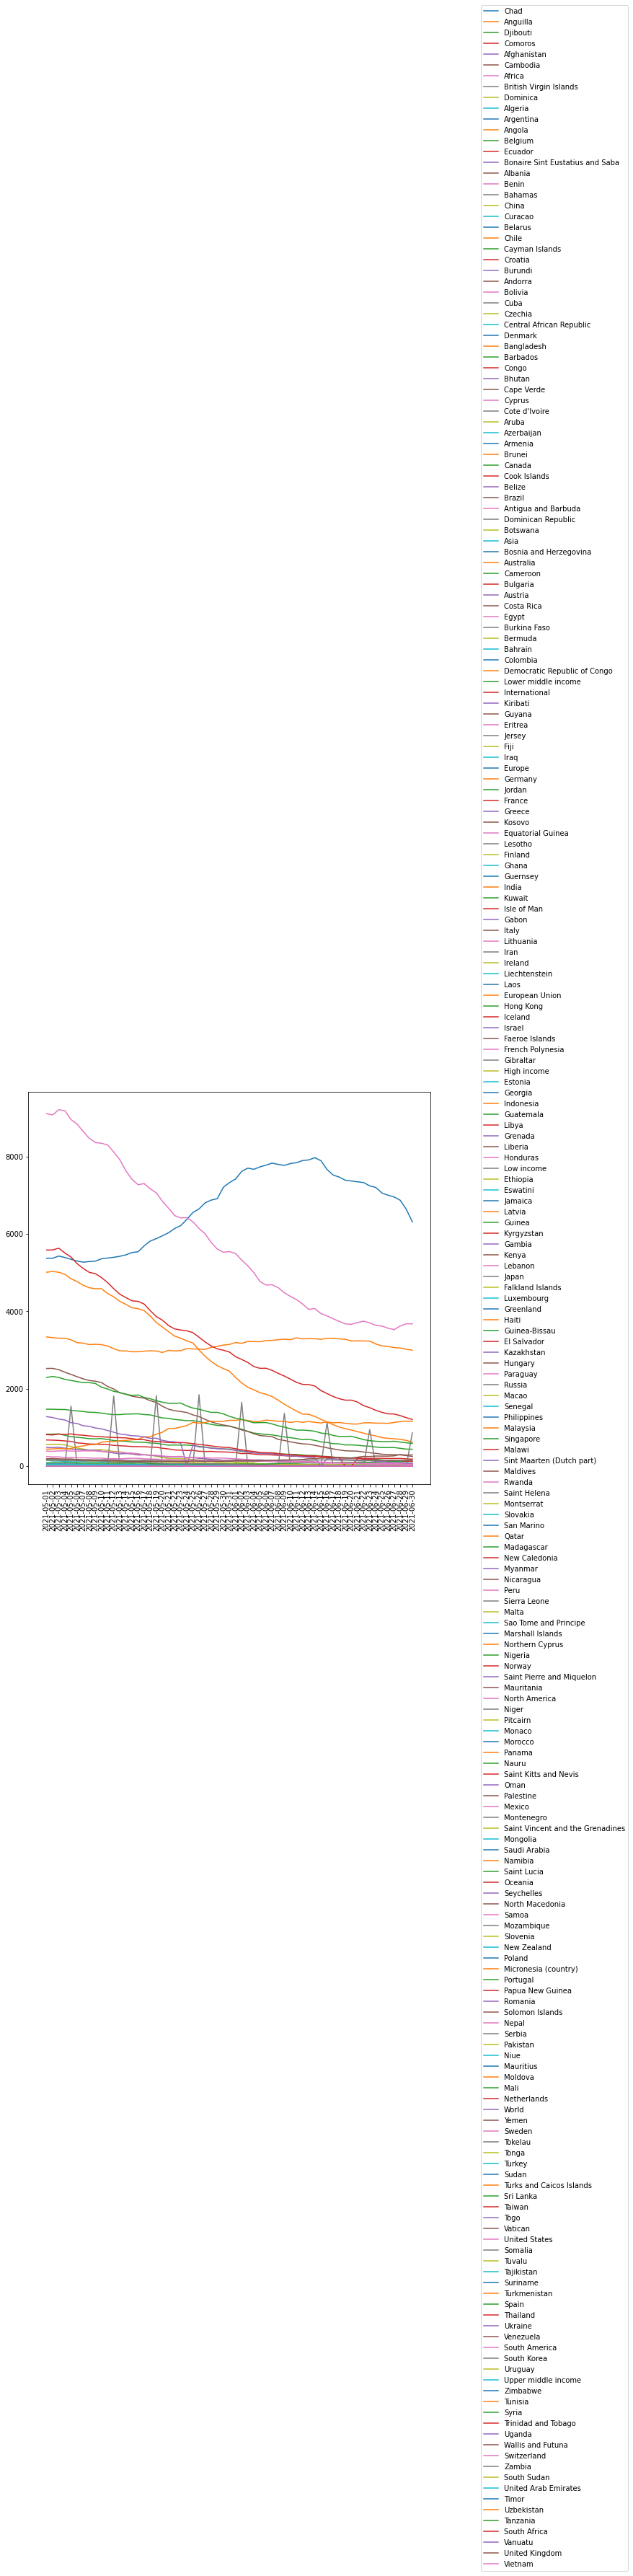

In [72]:
fig = plt.figure(figsize=(10, 10))
for country in icu.select('location').distinct().collect():
    c = icu.filter(icu.location == str(country[0])).toPandas()
    plt.plot(c['date'], c['icu_patients'], label = str(country[0]))

plt.xticks(rotation=90)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

Και εδώ οι παρατηρήσεις είναι παρόμοιες. Η τάση στις περισσότερες χώρες είναι πτωτική με εξαίρεση την χώρα που αντιπροσωπεύεται από την μπλε γραμμή. Υπάρχει και εδώ η καμπύλη με το τριγωνικό περιοδικό σχήμα, όπου μπορούμε να κάνουμε τα ίδια σχόλια με την περίπτωση των νοσηλευόμενων ασθενών.

### 6) Να κατασκευάσετε γεωγραφικό θερμοχάρτη (heatmap) του απόλυτου αριθμού κρουσμάτων.


Για το ερώτημα αυτό θα χρησιμοποιήσουμε την βιβλιοθήκη gmaps. Η βιβλιοθήκη αυτή απαιτεί να της δώσουμε ένα χαρακτηριστικό (π.χ. τον αριθμό κρουσμάτων) καθώς και το γεωγραφικό μήκος και πλάτος της χώρας που μας ενδιαφέρει. Επειδή το dataset δεν περιλαμβάνει τα γεωγραφικά αυτά χαρακτηριστικά, θα επιλέξουμε κάποιες χώρες που περιέχονται στο dataset και θα ψάξουμε στο διαδίκτυο να βρούμε τις τοποθεσίες τους. Για αυτές τις χώρες τελικά θα κάνουμε τον επιθυμητό χάρτη. Για την κάθε χώρα η ένταση του θερμοχάρτη θα είναι ανάλογη με τον μέσο αριθμό των συνολικών κρουσμάτων (total_cases) στο χρονικό διάστημα που μελετάται.

In [21]:
geolocations = {'Bulgaria' : [42.41, 23.19], 'Austria': [48.12, 16.21], 'Germany': [52.31, 13.23], 'France': [48.51, 2.21], 'Greece': [37.58, 23.43], 'Italy': [41.54, 12.29], 'Turkey': [40, 33], 'Spain': [40.26, -3]} 

Το παραπάνω λεξικό έχει ως κλειδιά τις χώρες και ως τιμές λίστες (γεωγραφικό πλάτος, γεωγραφικό μήκος) για την κάθε χώρα. Οι τοποθεσίες αυτές αφορούν την πρωτεύουσα της κάθε χώρας. Επιλέχθηκαν ενδεικτικά χώρες τις Ευρώπης.

In [22]:
locations = np.array([i for i in geolocations.values()])

In [23]:
max_cases = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'total_cases').groupBy('location').agg(F.mean('total_cases'))

In [24]:
max_cases.where("location = 'Greece' or location = 'Italy' or location = 'France' or location = 'Germany' or location = 'Spain' or location = 'Bulgaria' or location = 'Austria' or location = 'Turkey'").show()

+--------+-----------------+
|location| avg(total_cases)|
+--------+-----------------+
|Bulgaria|416882.9344262295|
| Austria|641914.4262295082|
| Germany|3653592.098360656|
|  France|5772235.163934426|
|  Greece| 395253.737704918|
|   Italy|4194618.606557377|
|  Turkey|5218464.934426229|
|   Spain|3674491.606557377|
+--------+-----------------+



In [25]:
weights = max_cases.where("location = 'Greece' or location = 'Italy' or location = 'France' or location = 'Germany' or location = 'Spain' or location = 'Bulgaria' or location = 'Austria' or location = 'Turkey'").select('avg(total_cases)').toPandas()

In [26]:
weights = weights['avg(total_cases)']

In [27]:
gmaps.configure(api_key="")
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights, point_radius=20))


In [28]:
fig

Figure(layout=FigureLayout(height='420px'))

Παρατηρούμε ότι οι χώρες με την μεγαλύτερη "ένταση" είναι η Γαλλία και η Τουρκία. Προφανώς πρέπει να σημειωθεί ότι χώρες όπως η Ελλάδα και η Βουλγαρία έχουν αρκετά μικρότερο πληθυσμό σε σχέση με την Τουρκία και την Γαλλία οπότε θα πρέπει να λάβουμε και αυτό υπ'όψιν όταν θα κάνουμε μελέτη ενός γεωθερμικού χάρτη.

### 7) Να εντοπίσετε παραδείγματα γειτονικών, μεταξύ τους, χωρών, που παρουσιάζουν μέγιστη συσχέτιση υπερβάλλουσας θνησιμότητας (excess mortality).

Για το ερώτημα αυτό θα μελετήσουμε κάποιες δυάδες γειτονικών χωρών. Από τις χώρες αυτές θα αντλήσουμε την μεταβλητή 'excess_mortality' και μέσω της συνάρτησης corrcoef της numpy θα δούμε κατά πόσο υπάρχει συσχέτιση μεταξύ του excess_mortality των χωρών (από τα μη-διαγώνια στοιχεία του πίνακα που θα μας επιστρέφει κάθε φορά)

In [52]:
df7 = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'excess_mortality', 'location')
df7 = df7.fillna({'excess_mortality': 0})

Η πρώτη δυάδα που θα μελετήσουμε θα είναι η Ελλάδα και η Ιταλία.

In [64]:
greece = df7.where("location = 'Greece'").toPandas()
italy = df7.where("location = 'Italy'").toPandas()
greece_mortality = greece['excess_mortality']
italy_mortality = italy['excess_mortality']
print('Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Ελλάδα και την Ιταλία είναι ο: ', '\n', np.corrcoef(greece_mortality, italy_mortality))

Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Ελλάδα και την Ιταλία είναι ο:  
 [[1.         0.91051521]
 [0.91051521 1.        ]]


Παρατηρούμε ότι τα μη-διαγώνια στοιχεία του πίνακα συσχέτισης είναι αρκετά κοντά στην μονάδα οπότε υπάρχει αρκετά μεγάλη συσχέτιση μεταξύ της υπερβάλλουσας θνησιμότητας της Ελλάδας και της Ιταλίας. Αυτό μπορεί να οφείλεται στο γεγονός ότι οι δύο αυτές χώρες συνδέονται άμεσα μέσω του τουρισμού.

Η επόμενη δυάδα είναι η Γαλλία και η Ισπανία.

In [66]:
spain = df7.where("location = 'Spain'").toPandas()
france = df7.where("location = 'France'").toPandas()
spain_mortality = spain['excess_mortality']
france_mortality = france['excess_mortality']
print('Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Ισπανία και την Γαλλία είναι ο: ', '\n', np.corrcoef(spain_mortality, france_mortality))

Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Ισπανία και την Γαλλία είναι ο:  
 [[1.         0.69797465]
 [0.69797465 1.        ]]


Σε αυτήν την περίπτωση η συσχέτιση δεν είναι τόσο έντονη (παρόλα αυτά ούτε και αμελητέα) καθώς τα μη-διαγώνια στοιχεία είναι αρκετά μακρία από την μονάδα.

Συνεχίζουμε με τον Καναδά και τις Ηνωμένες Πολιτείες

In [67]:
canada = df7.where("location = 'Canada'").toPandas()
us = df7.where("location = 'United States'").toPandas()
canada_mortality = canada['excess_mortality']
us_mortality = us['excess_mortality']
print('Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για τον Καναδά και τις Ηνωμένες Πολιτείες είναι ο: ', '\n', np.corrcoef(canada_mortality, us_mortality))

Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για τον Καναδά και τις Ηνωμένες Πολιτείες είναι ο:  
 [[1.         0.67436051]
 [0.67436051 1.        ]]


Και εδώ η συσχέτιση είναι παρόμοια με αυτήν της Ισπανίας και της Γαλλίας.
Συνεχίζουμε με Παραγουάη-Βολιβία

In [68]:
p = df7.where("location = 'Paraguay'").toPandas()
b = df7.where("location = 'Bolivia'").toPandas()
p_mortality = p['excess_mortality']
b_mortality = b['excess_mortality']
print('Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Παραγουάη και την Βολιβία είναι ο: ', '\n', np.corrcoef(p_mortality, b_mortality))

Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Παραγουάη και την Βολιβία είναι ο:  
 [[1.         0.96093513]
 [0.96093513 1.        ]]


Εδώ η συσχέτιση είναι φανερή. Ο δείκτης συσχέτισης είναι πάρα πολύ κοντά στην μονάδα, κάτι που σημαίνει ότι η υπερβάλλουσα θνησιμότητα της Παραγουάης είναι σε άμεση σχεδόν σχέση με αυτήν της Βολιβίας. Συνεχίζουμε με Σουηδία-Νορβηγία.

In [69]:
s = df7.where("location = 'Sweden'").toPandas()
n = df7.where("location = 'Norway'").toPandas()
s_mortality = s['excess_mortality']
n_mortality = n['excess_mortality']
print('Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Σουηδία και την Νορβηγία είναι ο: ', '\n', np.corrcoef(s_mortality, n_mortality))

Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Σουηδία και την Νορβηγία είναι ο:  
 [[ 1.         -0.42757654]
 [-0.42757654  1.        ]]


Η συσχέτιση εδώ φαίνεται να είναι αρκετά ασθενής. Παρόλο που η Σουηδία και η Νορβηγία είναι γειτονικές χώρες, φαίνεται ότι ο τρόπος με τον οποίο διαχειρίζονται την πανδημία τους επιτρέπει να μην επηρεάζονται από τις γειτονικές τους χώρες. Τελειώνουμε με την δυάδα Ισραήλ-Αίγυπτος.

In [72]:
i = df7.where("location = 'Israel'").toPandas()
e = df7.where("location = 'Egypt'").toPandas()
i_mortality = i['excess_mortality']
e_mortality = e['excess_mortality']
print('Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Αίγυπτο και το Ισραήλ είναι ο: ', '\n', np.corrcoef(i_mortality, e_mortality))

Ο πίνακας συσχέτισης της υπερβάλλουσας θνησιμότητας για την Αίγυπτο και το Ισραήλ είναι ο:  
 [[ 1.         -0.03584872]
 [-0.03584872  1.        ]]


Στην περίπτωση αυτήν παρατηρούμε σχεδόν ανύπαρκτη συσχέτιση μεταξύ της υπερβάλλουσας θνησιμότητας της Αιγύπτου και του Ισραήλ. Το Ισραήλ ήταν ανέκαθεν ένα πολύ αυστηρό κράτος σε ό,τι αφορά την διαχείριση της πανδημίας και για τον λόγο αυτόν ίσως να μην εμφανίζει κάποια συσχέτιση με τις άλλες γειτονικές χώρες.

Συνεπώς μέχρι τώρα έχουμε βρει δύο δυάδες γειτονικών μεταξύ τους χωρών που να έχουν μεγάλη συσχέτιση μεταξύ της υπερβάλλουσας θνησιμότητάς τους. Οι δυάδες αυτές είναι οι Ελλάδα-Ιταλία και Παραγουάη-Βολιβία. Η συσχέτιση της πρώτης δυάδας δικαιολογείται μέσω του τουρισμού, ενώ η συσχέτιση της δεύτερης ίσως να οφείλεται στο γεγονός ότι οι χώρες αυτές είναι σχετικά φτωχές και οι συνθήκες διαβίωσης ίσως επιτρέπουν στον κορωνοϊό να έχει μεγαλύτερη πιθανότητα εξάπλωσης στις γειτονικές χώρες.

### 8) Εκτιμείστε την εξάπλωση της λοίμωξης μέσω του ρυθμού αναπαραγωγής (reproduction rate) σε όλες τις Ηπείρους πλην Ανταρκτικής

In [132]:
continent_rate = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'continent', 'reproduction_rate')

In [133]:
for c in continent_rate.select('continent').distinct().collect():
    print(c)

Row(continent='Europe')
Row(continent='Africa')
Row(continent=None)
Row(continent='North America')
Row(continent='South America')
Row(continent='Oceania')
Row(continent='Asia')


Παρατηρούμε ότι στις παραπάνω ηπείρους δεν υπάρχει η ανταρκτική άρα δεν υπάρχει πρόβλημα σε αυτό. Υπάρχει όμως μία ήπειρος Νοne, την οποία δεν θα συμπεριλάβουμε. Απομονώνουμε σε ένα νέο dataframe μόνο τις υπόλοιπες ηπείρους.

In [134]:
continent_rate = continent_rate.where("continent = 'Europe' or continent = 'Asia' or continent = 'Africa' or continent = 'North America' or continent = 'South America' or continent = 'Oceania'")

In [135]:
for c in continent_rate.select('continent').distinct().collect():
    print(c)

Row(continent='Europe')
Row(continent='Africa')
Row(continent='North America')
Row(continent='South America')
Row(continent='Oceania')
Row(continent='Asia')


Τώρα θα πρέπει να συγκεντρώσουμε το παραπάνω dataframe σε επίπεδο χωρών. Για τον σκοπό αυτόν θα ομαδοποιήσουμε τα δεδομένα πρώτα με βάση τις ηπείρους και μετά με βάση την ημερομηνία. Επειδή όμως μία ήπειρος αποτελείται από πολλές χώρες, θα πάρουμε τον μέσο όρο των reproduction_rates και σε κάθε ημερομημία θα υπάρχει ένας reproduction_rate που θα θεωρηθεί αντιπροσωπευτικός για την συνολική ήπειρο για μία ημέρα

In [139]:
cr = continent_rate.groupBy('continent', 'date').agg(F.mean('reproduction_rate'))

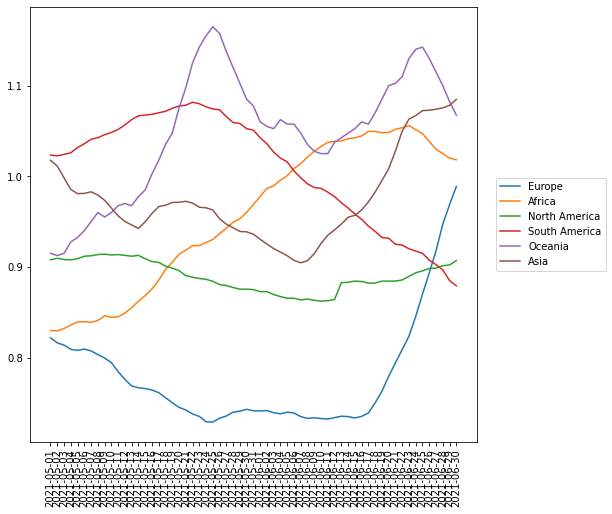

In [147]:
fig = plt.figure(figsize=(8, 8))
for continent in cr.select('continent').distinct().collect():
    c = cr.filter(cr.continent == str(continent[0])).sort('date').toPandas()
    plt.plot(c['date'], c['avg(reproduction_rate)'], label = str(continent[0]))

plt.xticks(rotation=90)
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.show()

Παρατηρούμε ότι αρχικά η Ευρώπη έχει τον μικρότερο ρυθμό αναπαραγωγής όμως από τα μέσα Ιουνίου και μετά αυτός αυξάνεται απότομα, κάτι που μπορεί να οφείλεται στον τουρισμό της Ευρώπης. Στην Αφρική ο ρυθμός αυξάνεται σχεδόν συνεχώς ενώ στην Νότια Αμερική αρχικά αυξάνεται και μετά μειώνεται. Στις υπόλοιπες ηπείρους υπάρχει μία αυξομείωση στον ρυθμό αναπαραγωγής χωρίς κάποιο άμεσα εμφανές μοτίβο.

### 9) Εμφανίστε τους καθημερινούς διαγνωστικούς ελέγχους ανά χώρα.

Στο ερώτημα αυτό επιλέγουμε τις στήλες date, location & total_tests. Θα σχηματισθούν οι χρονικές καμπύλες των total_tests. Πριν όμως σχεδιασθούν τα διαγράμματα θα γίνει ένα επιπλέον φιλτράρισμα στα δεδομένα. Γενικά παρατηρείται ότι αν μία χώρα αρχίζει (την 2021-05-01) με μηδενικά total_tests, θα συνεχίζει και έτσι μέχρι το τέλος (2021-06-30). Αυτό μπορεί να φανεί δοκιμάζοντας μερικές χώρες. Για τον λόγο αυτόν θα σχεδιάσουμε εκείνες τις χώρες οι οποίες την 2021-05-01 έχουν μη-μηδενικά total_tests.

In [148]:
tests = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'total_tests')

In [154]:
tests = tests.fillna({'total_tests': 0})

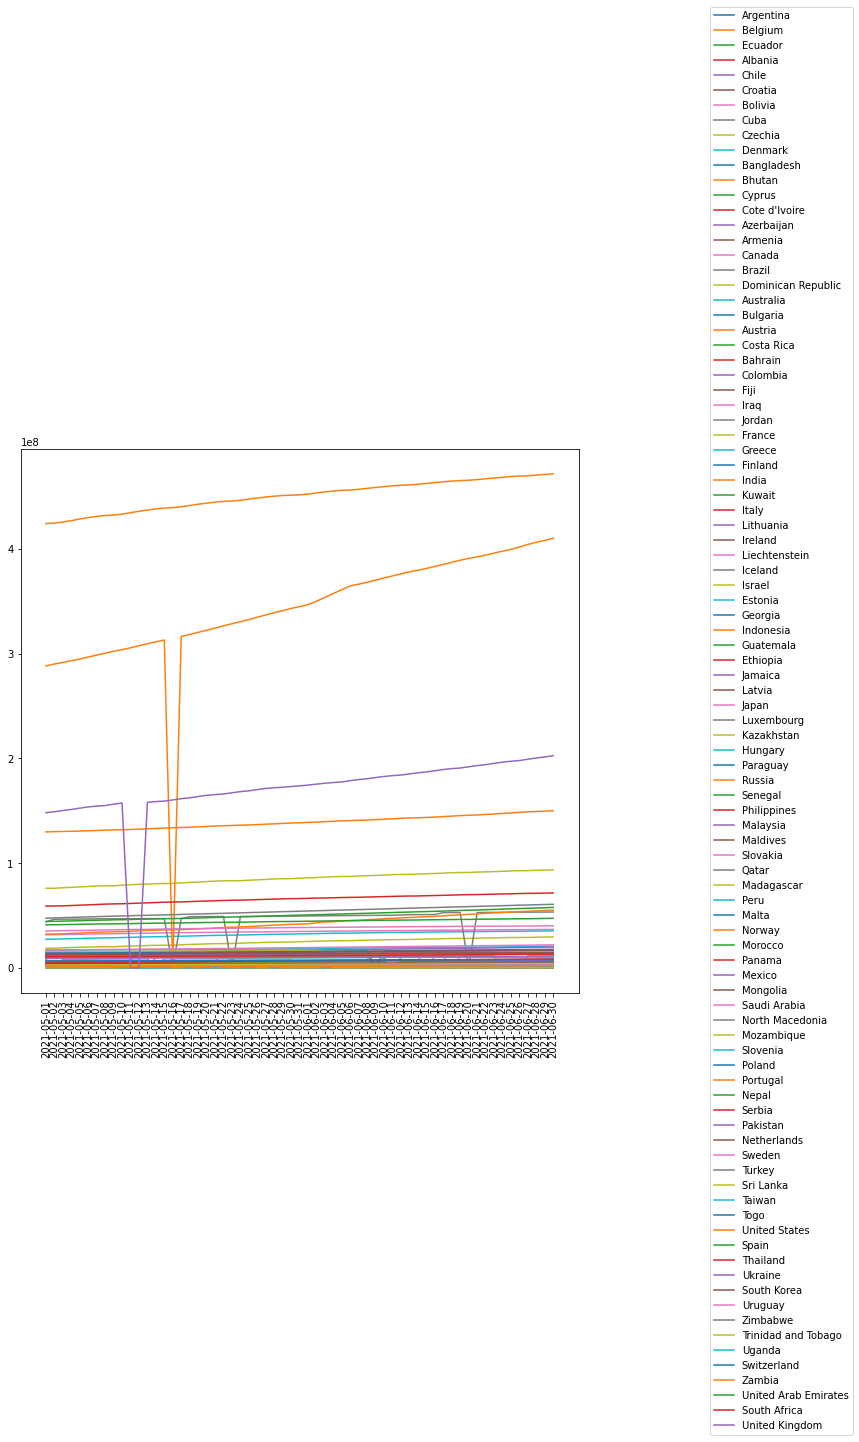

In [160]:
fig = plt.figure(figsize=(10, 10))
for country in tests.select('location').distinct().collect():
    c = tests.filter(tests.location == str(country[0])).toPandas()
    if c['total_tests'][0] != 0:
        plt.plot(c['date'], c['total_tests'], label = str(country[0]))

plt.xticks(rotation=90)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

Παρατηρούμε ότι κάποιες χώρες παρουσιάζουν κάποιες απότομες πτώσεις στον συνολικό αριθμό τεστ. Αυτές οι τιμές είναι κατά πάσα πιθανότητα έκτοπες τιμές (outliers). Παρόλα αυτά οι τιμές αυτές είναι λίγες και συνεπώς μπορούμε να πάρουμε μία ιδέα για την πορεία των συνολικών τεστ στις υπο-εξέταση χώρες. Η τάση των τεστ είναι είτε πρακτικά σταθερή ή οριακά αυξητική σε κάποιες περιπτώσεις.

### 10) Να μελετήσετε τη συσχέτιση μεταξύ του πλήθους των ελέγχων για κορονοϊό και της υπερβάλλουσας θνησιμότητας και να εμφανίσετε τις χώρες με τη μεγαλύτερη και τη μικρότερη συσχέτιση.

Για το ερώτημα αυτό θα κάνουμε δύο ελέγχους, μία για την μεταβλητή 'total_tests' και μία για την 'new_tests'. Για κάθε μία χώρα θα αντλήσουμε τις μεταβλητές 'excess_mortality' και 'total_tests' ('new_tests' αντίστοιχα) και θα υπολογίσουμε την συσχέτιση μεταξύ τους μέσω της corrcoef της numpy.

Ξεκινούμε την ανάλυση για την μεταβλητή 'total_tests'.

In [93]:
df10 = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'total_tests', 'excess_mortality')
df10 = df10.fillna({'total_tests': 0, 'excess_mortality': 0})

In [94]:
vax_mort_dict = {}

for country in df10.select('location').distinct().collect():
    c = df10.filter(df10.location == str(country[0])).toPandas()
    total_tests = c['total_tests']
    exc_mort = c['excess_mortality']
    vax_mort_dict[str(country[0])] = np.corrcoef(total_tests, exc_mort)[0, 1]
    

Επειδή υπάρχουν πάρα πολλές απουσιάζουσες τιμές στο dataset, πολλές τιμές του λεξικού υπολογίζονται ως nan. Για τον λόγο αυτόν πρώτα θα τις αφαιρέσουμε από το λεξικό και μετά θα τοποθετήσουμε τα κλειδιά σε φθίνουσα σειρά.

In [98]:
clean_dict = {k: vax_mort_dict[k] for k in vax_mort_dict if not isnan(vax_mort_dict[k])}
sorted_vm_dict = dict(sorted(clean_dict.items(), key=lambda item: item[1], reverse=True))

In [99]:
sorted_vm_dict

{'Germany': 0.7356385025752848,
 'Taiwan': 0.24827186637567855,
 'Russia': 0.22982884181159652,
 'Kosovo': 0.21076496285866436,
 'Thailand': 0.1947316938542687,
 'Bolivia': 0.17484832954275115,
 'Philippines': 0.1526227168913979,
 'Slovenia': 0.14682577912714737,
 'Georgia': 0.14551572288821846,
 'South Korea': 0.13354271011072133,
 'Paraguay': 0.12755728226780952,
 'Ukraine': 0.12733617796874497,
 'Qatar': 0.12586806658003585,
 'Bosnia and Herzegovina': 0.12215698433971652,
 'Finland': 0.1194697451889463,
 'Japan': 0.11376162454538448,
 'Serbia': 0.1128184355297477,
 'South Africa': 0.11229810058244565,
 'Panama': 0.10454945270316404,
 'Mongolia': 0.10119367727358182,
 'Uruguay': 0.09299049895926799,
 'Armenia': 0.07390999629815363,
 'Azerbaijan': 0.07293114725170298,
 'Brazil': 0.06734848964548704,
 'Portugal': 0.047964460340022455,
 'Estonia': 0.04324148278452637,
 'Norway': 0.0400818538280546,
 'Iceland': 0.03489502117729679,
 'Colombia': 0.0245383725475944,
 'United Kingdom': 0.02

Παρατηρούμε ότι οι χώρες με την μεγαλύτερη συσχέτιση ολικών ελέγχων και υπερβάλλουσαν θνησιμότητας είναι αυτές με τις μεγαλύτερες απόλυτες τιμές του δείκτη συσχέτισης, δηλαδή η Γερμανία και το Hong Kong. Ο δείκτης συσχέτισης είναι 0.7356 και -0.5541 αντίστοιχα. Οι χώρες με την μικρότερη συσχέτιση είναι αυτές για τις οποίες ο δείκτης συσχέτισης είναι πολύ κοντά στο 0, όπως για παράδειγμα η Αυστρία, το Καζακστάν, η Γουατεμάλα και το Ισραήλ. Παρατηρείται γενικά ότι δεν υπάρχει μεγάλη συσχέτιση μεταξύ των ολικών ελέγχων για κορωνοϊό και της υπερβάλλουσας θνησιμότητας.

Θα κάνουμε τώρα την ίδια ακριβώς ανάλυση αλλά με την μεταβλητή 'new_tests'.

In [100]:
df101 = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'new_tests', 'excess_mortality')
df101 = df101.fillna({'new_tests': 0, 'excess_mortality': 0})

In [101]:
test_mort_dict = {}

for country in df101.select('location').distinct().collect():
    c = df101.filter(df101.location == str(country[0])).toPandas()
    new_tests = c['new_tests']
    exc_mort = c['excess_mortality']
    test_mort_dict[str(country[0])] = np.corrcoef(new_tests, exc_mort)[0, 1]

In [103]:
clean_dict = {k: test_mort_dict[k] for k in test_mort_dict if not isnan(test_mort_dict[k])}
sorted_tests_dict = dict(sorted(clean_dict.items(), key=lambda item: item[1], reverse=True))

In [104]:
sorted_tests_dict

{'Mongolia': 0.5486650548809725,
 'Portugal': 0.45307542549710833,
 'Chile': 0.27136479131783464,
 'Luxembourg': 0.23440595677835063,
 'Norway': 0.19898118270498247,
 'Slovakia': 0.19663278166342557,
 'Cyprus': 0.16849326383595079,
 'Sweden': 0.16813403938478447,
 'Russia': 0.15516373224509328,
 'Taiwan': 0.1331751393719162,
 'Panama': 0.12566149734804047,
 'Malta': 0.08736164436827176,
 'Paraguay': 0.06989433082077627,
 'Croatia': 0.06956197085461079,
 'Qatar': 0.0609862098968232,
 'Thailand': 0.046807313971263254,
 'Bolivia': 0.032755395653197766,
 'New Zealand': 0.03078581896217162,
 'Liechtenstein': 0.029115951340424138,
 'Japan': 0.028164754646671824,
 'Kazakhstan': 0.009693230835411133,
 'Israel': 0.007488224718706072,
 'Hungary': -0.010447370907901012,
 'Philippines': -0.013079246592088681,
 'Armenia': -0.015015939231366592,
 'Kosovo': -0.023017288847081634,
 'Netherlands': -0.025701801353561128,
 'South Africa': -0.029434777855676535,
 'Azerbaijan': -0.03571015921327389,
 'Denm

Σε αυτήν την περίπτωση οι χώρες με την μεγαλύτερη συσχέτιση είναι οι: Περού, Γουατεμάλα, Λιθουανία και Μογκολία, ενώ χώρες με μηδαμινή συσχέτιση είναι οι: Καζακστάν, Ισραήλ, Ουγγαρία. Παρόλο που έχουν αλλάξει κάποιες χώρες ως προς τον βαθμό συσχέτισης των δύο μεταβλητών, η γενική τάση φαίνεται να δείχνει ότι δεν υπάρχει ιδιαίτερα έντονη συσχέτιση μεταξύ ελέγχων για κορωνοϊό και υπερβάλλουσαν θνησιμότητας.

### 11) Συσταδοποιείστε τις χώρες σε ομάδες ως προς τον αριθμό κρουσμάτων ανά εκατομμύριο και ως προς της υπερβάλλουσας θνησιμότητας ανά εκατομμύριο. Αναλύστε συνοπτικά τα ποιοτικά χαρακτηριστικά των συστάδων που λαμβάνετε.

Ξεκινάμε από τον αριθμό των κρουσμάτων ανά εκατομμύριο. Αυτό που θα κάνουμε είναι να δημιουργήσουμε δύο λίστες, μία θα περιέχει τις χώρες και η άλλη τον μέσο αριθμό των κρουσμάτων της κάθε χώρας στο χρονικό διάστημα που μας ενδιαφέρει. Θα δημιουργήσουμε ένα bar plot με αυτές τις δύο λίστες και θα προσπαθήσουμε να διακρίνουμε διάφορα όρια με βάση τα οποία θα βρούμε τις συστάδες.

In [5]:
cases_cluster = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'total_cases_per_million')

In [14]:
countries = []
mean_cases = []

for country in cases_cluster.select('location').distinct().collect():
    c = cases_cluster.filter(cases_cluster.location == str(country[0])).toPandas()
    countries.append(str(country[0]))
    mean_cases.append(np.mean(c['total_cases_per_million']))

In [36]:
data = list(zip(countries, mean_cases))

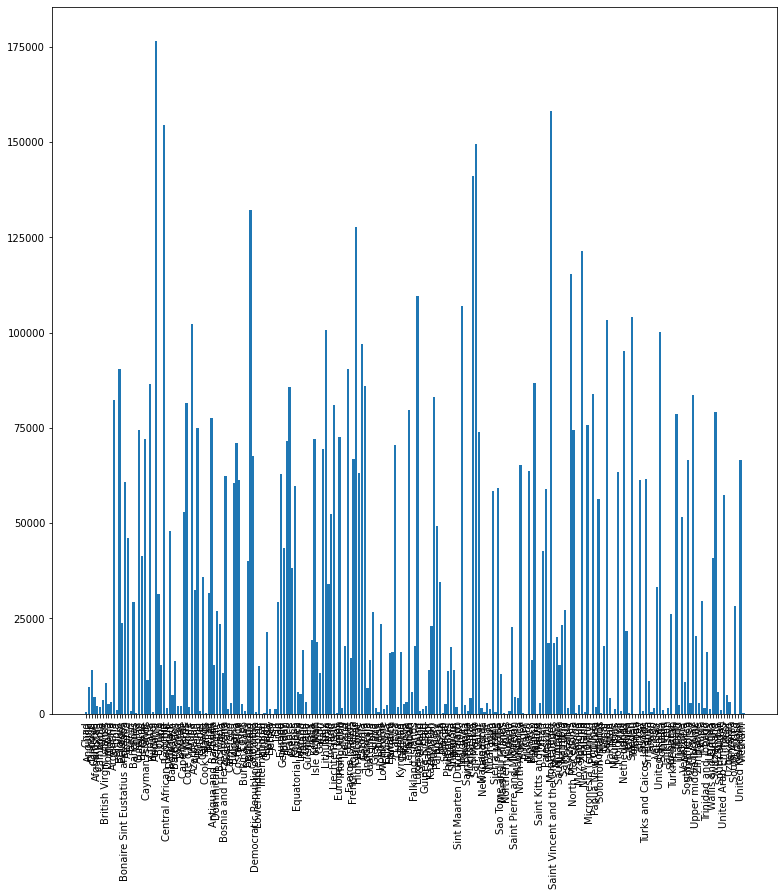

In [37]:
c = [str(data[i][0]) for i in range(len(data))]
m = [data[i][1] for i in range(len(data))]
fig = plt.figure(figsize=(13, 13))
plt.bar(c, m)
plt.xticks(rotation=90)
plt.show()

In [28]:
print(data)

[('Kiribati', 15.914318181818182), ('Cook Islands', 56.909000000000006), ('China', 63.13637704918033), ('Laos', 239.82714754098362), ('Chad', 290.78200000000004), ('Democratic Republic of Congo', 361.3904590163935), ('Burundi', 384.92014754098363), ('Liberia', 470.73240983606553), ('Brunei', 547.7203770491803), ('Burkina Faso', 624.5059999999999), ('Benin', 646.5737377049181), ('Angola', 994.2012295081969), ('Fiji', 1074.8619999999999), ('Australia', 1168.9243606557377), ('Low income', 1218.909442622951), ('Eritrea', 1237.6440327868852), ('Central African Republic', 1418.3163770491803), ('Grenada', 1422.9942786885242), ('Hong Kong', 1568.911163934426), ('Guinea', 1712.3662131147541), ("Cote d'Ivoire", 1746.1098360655735), ('Cambodia', 1830.2759016393445), ('Afghanistan', 1992.0758688524588), ('Bhutan', 2026.867704918033), ('Congo', 2078.0429016393446), ('Ethiopia', 2290.183557377049), ('Gambia', 2407.3526721311478), ('Egypt', 2489.6771475409832), ('Dominica', 2560.822180327868), ('Came

Οι συστάδες που θα επιλέξουμε θα γίνουν με βάση τον μέσο αριθμό κρουσμάτων. Οι κλάσσεις θα είναι οι εξής: 
(0, 15000), (15000, 50000), (50000, 100000) και (100000, ...)

In [38]:
few_cases = []
medium_cases = []
many_cases = []
too_many_cases = []


for i in range(len(data)):
    if data[i][1] > 0 and data[i][1] < 15000:
        few_cases.append(str(data[i][0]))
    elif data[i][1] > 15000 and data[i][1] < 50000:
        medium_cases.append(str(data[i][0]))
    elif data[i][1] > 50000 and data[i][1] < 100000:
        many_cases.append(str(data[i][0]))
    else:
        too_many_cases.append(str(data[i][0]))

In [39]:
print(few_cases)

['Chad', 'Anguilla', 'Djibouti', 'Comoros', 'Afghanistan', 'Cambodia', 'Africa', 'British Virgin Islands', 'Dominica', 'Algeria', 'Angola', 'Benin', 'China', 'Cayman Islands', 'Burundi', 'Cuba', 'Central African Republic', 'Bangladesh', 'Barbados', 'Congo', 'Bhutan', "Cote d'Ivoire", 'Brunei', 'Cook Islands', 'Antigua and Barbuda', 'Asia', 'Australia', 'Cameroon', 'Egypt', 'Burkina Faso', 'Democratic Republic of Congo', 'Lower middle income', 'Kiribati', 'Eritrea', 'Fiji', 'Equatorial Guinea', 'Lesotho', 'Ghana', 'Gabon', 'Laos', 'Hong Kong', 'Faeroe Islands', 'Indonesia', 'Guatemala', 'Grenada', 'Liberia', 'Low income', 'Ethiopia', 'Guinea', 'Gambia', 'Kenya', 'Japan', 'Greenland', 'Haiti', 'Guinea-Bissau', 'El Salvador', 'Macao', 'Senegal', 'Philippines', 'Singapore', 'Malawi', 'Rwanda', 'Saint Helena', 'Montserrat', 'Madagascar', 'New Caledonia', 'Myanmar', 'Nicaragua', 'Sierra Leone', 'Sao Tome and Principe', 'Marshall Islands', 'Nigeria', 'Saint Pierre and Miquelon', 'Mauritania',

Μία παρατήρηση που μπορεί να γίνει στην παραπάνω συστάδα είναι το γεγονός ότι περιλαμβάνει πολλές χώρες τις μέσης ανατολής και της Ασίας. Η Ιαπωνία, για παράδειγμα, η οποία έχει 125,8 εκατομμύρια ανθρώπους σε πληθυσμό, κατάφερε να είναι στις χώρες με σχετικά μικρό αριθμό κρουσμάτων. Αυτό οφείλεται στον τρόπο ζωής των ιαπώνων, οι οποίοι ακόμα και προ πανδημίας είχαν συνηθίσει να έχουν τις μάσκες στην καθημερινή τους ζωή.

In [40]:
print(medium_cases)

['Ecuador', 'Albania', 'Bahamas', 'Belarus', 'Bolivia', 'Denmark', 'Azerbaijan', 'Canada', 'Belize', 'Dominican Republic', 'Botswana', 'Bermuda', 'Guyana', 'Iraq', 'Germany', 'Greece', 'Finland', 'India', 'Isle of Man', 'Iran', 'Iceland', 'Libya', 'Honduras', 'Eswatini', 'Jamaica', 'Kyrgyzstan', 'Falkland Islands', 'Kazakhstan', 'Paraguay', 'Russia', 'Malaysia', 'Norway', 'Oman', 'Mexico', 'Saint Vincent and the Grenadines', 'Mongolia', 'Namibia', 'Saint Lucia', 'Nepal', 'World', 'Vatican', 'Suriname', 'Upper middle income', 'Tunisia', 'Trinidad and Tobago', 'Wallis and Futuna', 'South Africa']


Παρατηρούμε ότι αρκετές χώρες της Ευρώπης βρίσκονται σε αυτήν την συστάδα, π.χ. η Ελλάδα, η Γερμανία και η Ρωσία. Περιλαμβάνονται επίσης και άλλες χώρες με σχετικά μικρό πληθυσμό, όπως το Μεξικό, το Ιράν και η Βολιβία.

In [41]:
print(many_cases)

['Argentina', 'Belgium', 'Bonaire Sint Eustatius and Saba', 'Curacao', 'Chile', 'Croatia', 'Cape Verde', 'Cyprus', 'Armenia', 'Brazil', 'Bosnia and Herzegovina', 'Bulgaria', 'Austria', 'Costa Rica', 'Colombia', 'Europe', 'Jordan', 'France', 'Kosovo', 'Kuwait', 'Italy', 'Ireland', 'Liechtenstein', 'European Union', 'Israel', 'French Polynesia', 'High income', 'Estonia', 'Georgia', 'Latvia', 'Lebanon', 'Hungary', 'Qatar', 'Peru', 'Malta', 'North America', 'Monaco', 'Panama', 'Palestine', 'North Macedonia', 'Poland', 'Portugal', 'Romania', 'Moldova', 'Netherlands', 'Turkey', 'Turks and Caicos Islands', 'Spain', 'Ukraine', 'South America', 'Uruguay', 'Switzerland', 'United Arab Emirates', 'United Kingdom']


In [42]:
print(too_many_cases)

['Andorra', 'Czechia', 'Aruba', 'Bahrain', 'International', 'Jersey', 'Guernsey', 'Lithuania', 'Gibraltar', 'Luxembourg', 'Sint Maarten (Dutch part)', 'Maldives', 'Slovakia', 'San Marino', 'Northern Cyprus', 'Pitcairn', 'Nauru', 'Montenegro', 'Seychelles', 'Slovenia', 'Serbia', 'Niue', 'Sweden', 'Tokelau', 'Tonga', 'United States', 'Tuvalu', 'Turkmenistan']


Οι παραπάνω χώρες είναι αυτές που είχαν τον μεγαλύτερο αριθμό μέσων κρουσμάτων στο διάστημα που μελετάμε. Οι Ηνωμένες Πολιτείες είναι σε αυτήν την λίστα. Αυτό μπορεί να οφείλεται τόσο στον τεράστιο πληθυσμό της όσο και στην διαχείριση του κρατικού μηχανισμού σε ό,τι αφορά την πανδημία. Οι υπόλοιπες χώρες δεν παρουσιάζουν κάποιο κοινό μοτίβο σε ό,τι αφορά την τοποθεσία τους στον πλανήτη.

Συνεχίζουμε με την θνησιμότητα. Εδώ θα χρειαστούμε την μεταβλητή excess_mortality_cumulative_per_million. Η λογική είναι παρόμοια με την περίπτωση των κρουσμάτων, μόνο που εδώ αντί για την μέση τιμή θα χρησιμοποιήσουμε την μέγιστη τιμή, καθώς οι τιμές είναι συσσωρευμένες (cumulative).

In [62]:
mortality_cluster = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'excess_mortality_cumulative_per_million')
mortality_cluster = mortality_cluster.fillna({'excess_mortality_cumulative_per_million': 0})

In [67]:
countries = []
max_mortality = []

for country in mortality_cluster.select('location').distinct().collect():
    c = mortality_cluster.filter(mortality_cluster.location == str(country[0])).toPandas()
    countries.append(str(country[0]))
    max_mortality.append(np.max(c['excess_mortality_cumulative_per_million']))

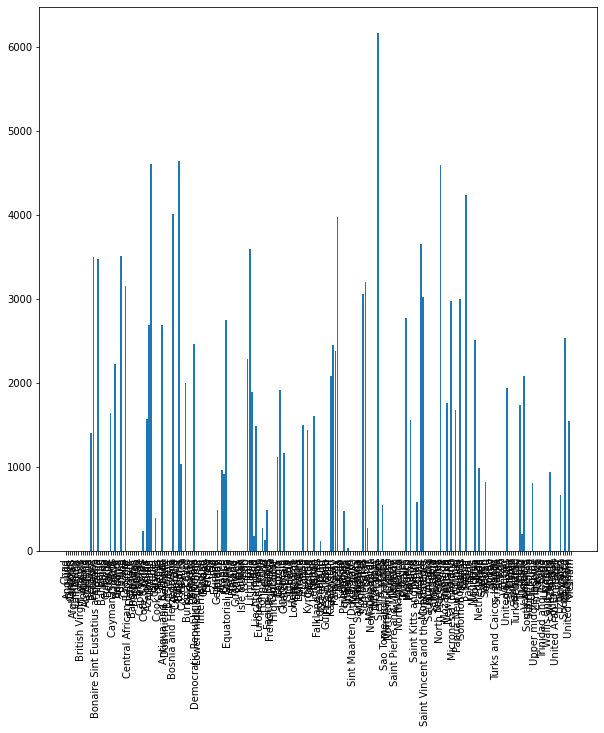

In [68]:
fig = plt.figure(figsize=(10, 10))
plt.bar(countries, max_mortality)
plt.xticks(rotation=90)
plt.show()

Ο λόγος που το παραπάνω διάγραμμα είναι τόσο αραιό είναι επειδή υπάρχουν πάρα πολλές απουσιάζουσες τιμές στο dataframe. Προφανώς θα μπορούσαμε αυτές τις χώρες να μην τις συμπεριλάβουμε στο παρόν ερώτημα. Οι συστάδες που θα χρησιμοποιήσουμε τώρα θα είναι οι (0, 1500), (1500, 3000), (3000, 4500) και (4500, ...)

In [ ]:
small_mortality = []
medium_mortality = []
big_mortality = []
large_mortality = []
data = list(zip(countries, max_mortality))


#Σημείωση: Δεν περιλαμβάνουμε τις χώρες που μας έχουν δώσει μηδενικό excess_mortality

for i in range(len(data)):
    if data[i][1] > 0 and data[i][1] < 1500 and data[i][1] != 0:
        small_mortality.append(str(data[i][0]))
    elif data[i][1] > 1500 and data[i][1] < 3000:
        medium_mortality.append(str(data[i][0]))
    elif data[i][1] > 3000 and data[i][1] < 4500:
        big_mortality.append(str(data[i][0]))
    elif data[i][1] > 4500:
        large_mortality.append(str(data[i][0]))

In [75]:
print(small_mortality)

['Belgium', 'Cyprus', 'Canada', 'Austria', 'Germany', 'France', 'Greece', 'Ireland', 'Liechtenstein', 'Hong Kong', 'Iceland', 'Israel', 'Estonia', 'Guatemala', 'Kyrgyzstan', 'Luxembourg', 'Philippines', 'Singapore', 'Qatar', 'Malta', 'Oman', 'Netherlands', 'Sweden', 'Thailand', 'Uruguay', 'Switzerland', 'Uzbekistan']


In [76]:
print(medium_mortality)

['Chile', 'Croatia', 'Aruba', 'Azerbaijan', 'Brazil', 'Egypt', 'Colombia', 'Kosovo', 'Italy', 'Iran', 'Georgia', 'Latvia', 'Lebanon', 'Kazakhstan', 'Hungary', 'Paraguay', 'Monaco', 'Panama', 'Slovenia', 'Poland', 'Portugal', 'Romania', 'Moldova', 'United States', 'Spain', 'Ukraine', 'South Africa', 'United Kingdom']


In [77]:
print(big_mortality)

['Ecuador', 'Albania', 'Bolivia', 'Czechia', 'Bosnia and Herzegovina', 'Lithuania', 'Russia', 'Slovakia', 'San Marino', 'Mexico', 'Montenegro', 'Serbia']


In [78]:
print(large_mortality)

['Armenia', 'Bulgaria', 'Peru', 'North Macedonia']


### 12) Να υπολογίσετε τη συσχέτιση μεταξύ πορείας εμβολιασμών (αν υπάρχουν την χρονική περίοδο που μελετάτε) και της υπερβάλλουσας θνησιμότητας και να εμφανίσετε τις χώρες με τη μεγαλύτερη και τη μικρότερη συσχέτιση.

Η λογική αυτού του ερωτήματος είναι παρόμοια με αυτήν του ερωτήματος 10. Εδώ θα χρησιμοποιήσουμε τις μεταβλητές 'total_vaccinations', 'total_boosters' και 'people_fully_vaccinated'.

Ξεκινάμε με την μεταβλητή 'total_vaccinations'

In [106]:
df121 = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'total_vaccinations', 'excess_mortality')
df121 = df121.fillna({'total_vaccinations': 0, 'excess_mortality': 0})

In [107]:
tvax_mort_dict = {}

for country in df121.select('location').distinct().collect():
    c = df121.filter(df121.location == str(country[0])).toPandas()
    total_vacc = c['total_vaccinations']
    exc_mort = c['excess_mortality']
    tvax_mort_dict[str(country[0])] = np.corrcoef(total_vacc, exc_mort)[0, 1]

In [110]:
clean_dict = {k: tvax_mort_dict[k] for k in tvax_mort_dict if not isnan(tvax_mort_dict[k])}
sorted_tvax_dict = dict(sorted(clean_dict.items(), key=lambda item: item[1], reverse=True))
sorted_tvax_dict

{'Slovakia': 0.7558313378463192,
 'Finland': 0.5533847189754698,
 'Taiwan': 0.27364172272792614,
 'Seychelles': 0.22846574307145834,
 'Macao': 0.21956117566307218,
 'Russia': 0.2095878916466905,
 'Luxembourg': 0.20584533442009378,
 'Thailand': 0.20470086369535553,
 'Azerbaijan': 0.18753471087239537,
 'Bolivia': 0.18644387693141914,
 'Panama': 0.18470569186101735,
 'Moldova': 0.16526328721550795,
 'South Korea': 0.16113455140621455,
 'Georgia': 0.1548230777371792,
 'North Macedonia': 0.1524821491241935,
 'Brazil': 0.14863514241339895,
 'United Kingdom': 0.1390186897831897,
 'Slovenia': 0.13797198184216883,
 'Ukraine': 0.1360962462251776,
 'Paraguay': 0.13519510997062292,
 'Kazakhstan': 0.13297839116624843,
 'Qatar': 0.12688653923697368,
 'Singapore': 0.12657883816318444,
 'Spain': 0.12382482554610523,
 'Japan': 0.11661360267592617,
 'Colombia': 0.11128770782961057,
 'Mongolia': 0.10896590943267488,
 'Uruguay': 0.10513098795011432,
 'French Polynesia': 0.07457123214651169,
 'Kosovo': 0.0

Χώρες με σχετικά μεγάλη συσχέτιση ολικών εμβολιασμών και υπερβάλλουσαν θνησιμότητας είναι η Σλοβακία, η Ελλάδα και η Φιλανδία, ενώ χώρες με μικρή συσχέτιση είναι η Αυστρία, η Ουγγαρία και η Αλβανία.

Συνεχίζουμε με την μεταβλητή 'total_booosters'.

In [111]:
df122 = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'total_boosters', 'excess_mortality')
df122 = df122.fillna({'total_boosters': 0, 'excess_mortality': 0})

In [112]:
boost_mort_dict = {}

for country in df122.select('location').distinct().collect():
    c = df122.filter(df122.location == str(country[0])).toPandas()
    total_boosts = c['total_boosters']
    exc_mort = c['excess_mortality']
    boost_mort_dict[str(country[0])] = np.corrcoef(total_boosts, exc_mort)[0, 1]

In [113]:
clean_dict = {k: boost_mort_dict[k] for k in boost_mort_dict if not isnan(boost_mort_dict[k])}
sorted_boosts_dict = dict(sorted(clean_dict.items(), key=lambda item: item[1], reverse=True))
sorted_boosts_dict

{'Slovakia': 0.7772493855862441,
 'Luxembourg': 0.2069545917470101,
 'South Korea': 0.1637263392938435,
 'Uruguay': 0.12710717783964293,
 'Lithuania': 0.027285443336461324,
 'Norway': 0.020848524856885497,
 'Austria': 0.0061457204502629054,
 'Latvia': 0.0018528764581290406,
 'Germany': -0.00334213112919074,
 'Czechia': -0.02195157740621174,
 'Canada': -0.11035818622246828,
 'Switzerland': -0.11579171896137666,
 'New Zealand': -0.11725119645081991,
 'Peru': -0.16176762099245026,
 'Hong Kong': -0.16431879250533024,
 'France': -0.30966450158428915,
 'Denmark': -0.44687009913826786}

Και εδώ η χώρα με την μεγαλύτερη συσχέτιση είναι η Σλοβακία, ενώ χώρες με μικρή συσχέτιση είναι η Αυστρία, η Νορβηγία και η Λατβία.

Τελειώνουμε με την μεταβλητή 'people_fully_vaccinated'.

In [114]:
df123 = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'excess_mortality', 'people_fully_vaccinated')
df123 = df123.fillna({'people_fully_vaccinated': 0, 'excess_mortality': 0})

In [115]:
pfv_mort_dict = {}

for country in df123.select('location').distinct().collect():
    c = df123.filter(df123.location == str(country[0])).toPandas()
    pfv = c['people_fully_vaccinated']
    exc_mort = c['excess_mortality']
    pfv_mort_dict[str(country[0])] = np.corrcoef(pfv, exc_mort)[0, 1]

In [116]:
clean_dict = {k: pfv_mort_dict[k] for k in pfv_mort_dict if not isnan(pfv_mort_dict[k])}
sorted_pfv_dict = dict(sorted(clean_dict.items(), key=lambda item: item[1], reverse=True))
sorted_pfv_dict

{'Slovakia': 0.722476402474671,
 'Finland': 0.5787343063671792,
 'Taiwan': 0.35696533917933615,
 'Seychelles': 0.23540954131322248,
 'Thailand': 0.21221147878064087,
 'Macao': 0.20936678214156912,
 'Azerbaijan': 0.20727132253496805,
 'Russia': 0.20032389299112088,
 'Ukraine': 0.196976170638028,
 'Panama': 0.19320388479612813,
 'Bolivia': 0.17909643044926776,
 'Brazil': 0.15891401357815463,
 'Moldova': 0.1491813030679611,
 'Georgia': 0.14712943691413263,
 'United Kingdom': 0.1447987047888243,
 'Paraguay': 0.14106512070044794,
 'Mongolia': 0.13737372561695999,
 'Qatar': 0.13706008740457928,
 'Kosovo': 0.13660530253592218,
 'Kazakhstan': 0.13362964308351005,
 'South Korea': 0.1314384294365092,
 'Japan': 0.12985702304608657,
 'Singapore': 0.12066320215773078,
 'Slovenia': 0.11943802776653814,
 'North Macedonia': 0.11447410459853292,
 'Uruguay': 0.1087969415785265,
 'Spain': 0.10351840466831679,
 'Colombia': 0.10046364209208138,
 'Philippines': 0.09213207596856948,
 'Hungary': 0.07469462878

Οι χώρες με την μεγαλύτερη συσχέτιση είναι και εδώ η Σλοβακία και η Φιλανδία, ενώ χώρες με μικρή συσχέτιση είναι όπως και πριν η Αυστρία, η Κροατία και η Λατβία. 

Προφανώς και οι τρεις μεταβλητές δίνουν παρόμοια αποτελέσματα καθώς δεν είναι άσχετες μεταξύ τους. Το πόσοι άνθρωποι είναι πλήρως εμβολιασμένοι έχει άμεση σχέση με τον συνολικό αριθμό των εμβολιασμών.

### 13) Καθορίστε ποια είναι τα χαρακτηριστικά των χωρών με τη μεγαλύτερη και τη μικρότερη υπερβάλλουσα θνησιμότητα λόγω Covid, όσον αφορά τη γενική υγεία του πληθυσμού τους (πχ κάπνισμα, διαβήτης, καρδιοπάθειες κλπ).

Για το ερώτημα αυτό θα πάρουμε τις 5 χώρες με την μεγαλύτερη και την μικρότερη υπερβάλλουσα θνησιμότητα (από το ερώτημα 1). Οι 5 χώρες με την μεγαλύτερη θνησιμότητα είναι οι : (Peru, Paraguay, Bolivia, Oman, Colombia), ενώ οι 5 χώρες με την μικρότερη θνησιμότητα είναι οι (Aruba, Macao, Switzerland, South Korea, Sweden).

In [13]:
biggest_mortality = df.filter(df.date.between("2021-05-01", "2021-06-30")).where("location = 'Peru' or location = 'Paraguay' or location = 'Bolivia' or location = 'Oman' or location = 'Colombia'")
smallest_mortality = df.filter(df.date.between("2021-05-01", "2021-06-30")).where("location = 'Aruba' or location = 'Macao' or location = 'South Korea' or location = 'Switzerland' or location = 'Sweden'")

Ξεκινάμε κάνοντας μία διερεύνηση για το μέσο ποσοστό καπνιζόντων στις χώρες αυτές.

In [15]:
print('Το μέσο ποσοστό των ανδρών καπνιστών στις χώρες με την μικρότερη θνησιμότητα είναι: ')
smallest_mortality.groupBy('location').agg(F.mean('male_smokers')).show()
print('Το μέσο ποσοστό των ανδρών καπνιστών στις χώρες με την μεγαλύτερη θνησιμότητα είναι: ')
biggest_mortality.groupBy('location').agg(F.mean('male_smokers')).show()

Το μέσο ποσοστό των ανδρών καπνιστών στις χώρες με την μικρότερη θνησιμότητα είναι: 
+-----------+------------------+
|   location| avg(male_smokers)|
+-----------+------------------+
|      Aruba|              null|
|      Macao|              null|
|     Sweden|18.899999999999995|
|South Korea| 40.90000000000005|
|Switzerland|28.900000000000027|
+-----------+------------------+

Το μέσο ποσοστό των ανδρών καπνιστών στις χώρες με την μεγαλύτερη θνησιμότητα είναι: 
+--------+------------------+
|location| avg(male_smokers)|
+--------+------------------+
| Bolivia|              null|
|Colombia|              13.5|
|Paraguay| 21.59999999999999|
|    Peru|              null|
|    Oman|15.600000000000016|
+--------+------------------+



In [16]:
print('Το μέσο ποσοστό των γυναικών καπνιστών στις χώρες με την μικρότερη θνησιμότητα είναι: ')
smallest_mortality.groupBy('location').agg(F.mean('female_smokers')).show()
print('Το μέσο ποσοστό των γυναικών καπνιστών στις χώρες με την μεγαλύτερη θνησιμότητα είναι: ')
biggest_mortality.groupBy('location').agg(F.mean('female_smokers')).show()

Το μέσο ποσοστό των γυναικών καπνιστών στις χώρες με την μικρότερη θνησιμότητα είναι: 
+-----------+-------------------+
|   location|avg(female_smokers)|
+-----------+-------------------+
|      Aruba|               null|
|      Macao|               null|
|     Sweden|  18.79999999999998|
|South Korea|  6.199999999999993|
|Switzerland| 22.599999999999987|
+-----------+-------------------+

Το μέσο ποσοστό των γυναικών καπνιστών στις χώρες με την μεγαλύτερη θνησιμότητα είναι: 
+--------+-------------------+
|location|avg(female_smokers)|
+--------+-------------------+
| Bolivia|               null|
|Colombia|  4.699999999999995|
|Paraguay|                5.0|
|    Peru|  4.800000000000006|
|    Oman|                0.5|
+--------+-------------------+



Παρατηρούμε ότι στις χώρες με την μεγαλύτερη θνησιμότητα υπάρχουν και περισσότεροι καπνιστές. Παρατηρούμε επίσης ότι καπνίζουν κατά μέσο όρο περισσότεροι άντρες παρά γυναίκες.

Συνεχίζουμε με το ποσοστό επικράτησης του διαβήτη (diabetes_prevalence)

In [17]:
print('Το μέσο ποσοστό των διαβητικών στις χώρες με την μικρότερη θνησιμότητα είναι: ')
smallest_mortality.groupBy('location').agg(F.mean('diabetes_prevalence')).show()
print('Το μέσο ποσοστό των διαβητικών στις χώρες με την μεγαλύτερη θνησιμότητα είναι: ')
biggest_mortality.groupBy('location').agg(F.mean('diabetes_prevalence')).show()

Το μέσο ποσοστό των διαβητικών στις χώρες με την μικρότερη θνησιμότητα είναι: 
+-----------+------------------------+
|   location|avg(diabetes_prevalence)|
+-----------+------------------------+
|      Aruba|      11.620000000000003|
|      Macao|                    null|
|     Sweden|                    4.79|
|South Korea|       6.800000000000007|
|Switzerland|       5.589999999999995|
+-----------+------------------------+

Το μέσο ποσοστό των διαβητικών στις χώρες με την μεγαλύτερη θνησιμότητα είναι: 
+--------+------------------------+
|location|avg(diabetes_prevalence)|
+--------+------------------------+
| Bolivia|       6.889999999999991|
|Colombia|       7.439999999999999|
|Paraguay|       8.269999999999992|
|    Peru|       5.949999999999993|
|    Oman|       12.61000000000001|
+--------+------------------------+



Παρατηρούμε ότι το μέσο ποσοστό των διαβητικών είναι ίσως ελαφρώς μικρότερο στις χώρες όπου η θνησιμότητα είναι μικρότερη. Αυτό είναι λογικό καθώς ο διαβήτης είναι ένα από τα υποκείμενα νοσήματα που επιδεινώνουν την κατάσταση του ασθενούς που πάσχει από κορωνοϊό.

Τελειώνουμε με τον ρυθμό θανάτων από καρδιαγγειακές ασθένειες.

In [19]:
print('Ο μέσος ρυθμός θανάτων από καρδιαγγειακές ασθένειες στις χώρες με την μικρότερη θνησιμότητα είναι: ')
smallest_mortality.groupBy('location').agg(F.mean('cardiovasc_death_rate')).show()
print('Ο μέσος ρυθμός θανάτων από καρδιαγγειακές ασθένειες στις χώρες με την μεγαλύτερη θνησιμότητα είναι: ')
biggest_mortality.groupBy('location').agg(F.mean('cardiovasc_death_rate')).show()

Ο μέσος ρυθμός θανάτων από καρδιαγγειακές ασθένειες στις χώρες με την μικρότερη θνησιμότητα είναι: 
+-----------+--------------------------+
|   location|avg(cardiovasc_death_rate)|
+-----------+--------------------------+
|      Aruba|                      null|
|      Macao|                      null|
|     Sweden|                   133.982|
|South Korea|         85.99799999999993|
|Switzerland|         99.73899999999988|
+-----------+--------------------------+

Ο μέσος ρυθμός θανάτων από καρδιαγγειακές ασθένειες στις χώρες με την μεγαλύτερη θνησιμότητα είναι: 
+--------+--------------------------+
|location|avg(cardiovasc_death_rate)|
+--------+--------------------------+
| Bolivia|         204.2990000000003|
|Colombia|        124.23999999999984|
|Paraguay|         199.1280000000001|
|    Peru|         85.75500000000008|
|    Oman|         266.3420000000002|
+--------+--------------------------+



Και εδώ παρατηρούμε ότι οι καρδιαγγειακές ασθένειες είναι καθοριστικός παράγοντας σε ό,τι αφορά την διαμόρφωση της θνησιμότητας από κορωνοϊό. Τα δεδομένα αυτά αφορούν τους θανάτους του έτους 2017, δηλαδή δύο χρόνια πριν την εμφάνιση του κορωνοϊού, αλλά προφανώς τα ποσοστό αυτά δεν αναμένεται να είναι πολύ διαφορετικά τα επόμενα χρόνια.

### 14) Να εξετάσετε την πορεία εξάπλωσης του ιού ως προς τον δείκτη ανθρώπινης ανάπτυξης (human development index) και να σχηματίσετε συστάδες χωρών με παρόμοια χαρακτηριστικά. Αναλύστε συνοπτικά τα ποιοτικά χαρακτηριστικά των συστάδων που λαμβάνετε.

Για το ερώτημα αυτό θα κάνουμε το εξής: θα πάρουμε τις στήλες date, location, human_development_index και positive_rate. Στην συνέχεια θα σχηματίσουμε δύο ραβδογράμματα, ένα για το μέσο human_development_index της κάθε χώρας και ένα για το μέσο positive_rate για την κάθε χώρα. Και εδώ θα αποκλείσουμε τις χώρες που την 2021-05-01 έχουν μηδενικό human_development_index και μηδενικό positive_rate ταυτόχρονα. Εφόσον κάνουμε τα δύο ραβδογράμματα θα δούμε κατά πόσο χώρες με μεγάλο human_development_index έχουν μικρό μέσο positive_rate και αντιστρόφως.

In [69]:
hdi = df.filter(df.date.between("2021-05-01", "2021-06-30")).select('date', 'location', 'human_development_index', 'positive_rate')
hdi = hdi.fillna({'human_development_index': 0, 'positive_rate': 0})

In [70]:
countries = []
hdis = []
prs = []

for country in hdi.select('location').distinct().collect():
    c = hdi.filter(hdi.location == str(country[0])).toPandas()
    if c['human_development_index'][0] != 0 and c['positive_rate'][0] != 0:
        countries.append(str(country[0]))
        hdis.append(np.mean(c['human_development_index']))
        prs.append(np.mean(c['positive_rate']))

In [71]:
data  = list(zip(countries, hdis, prs))

Ραβδόγραμμα του μέσου human_development_index για την κάθε χώρα:


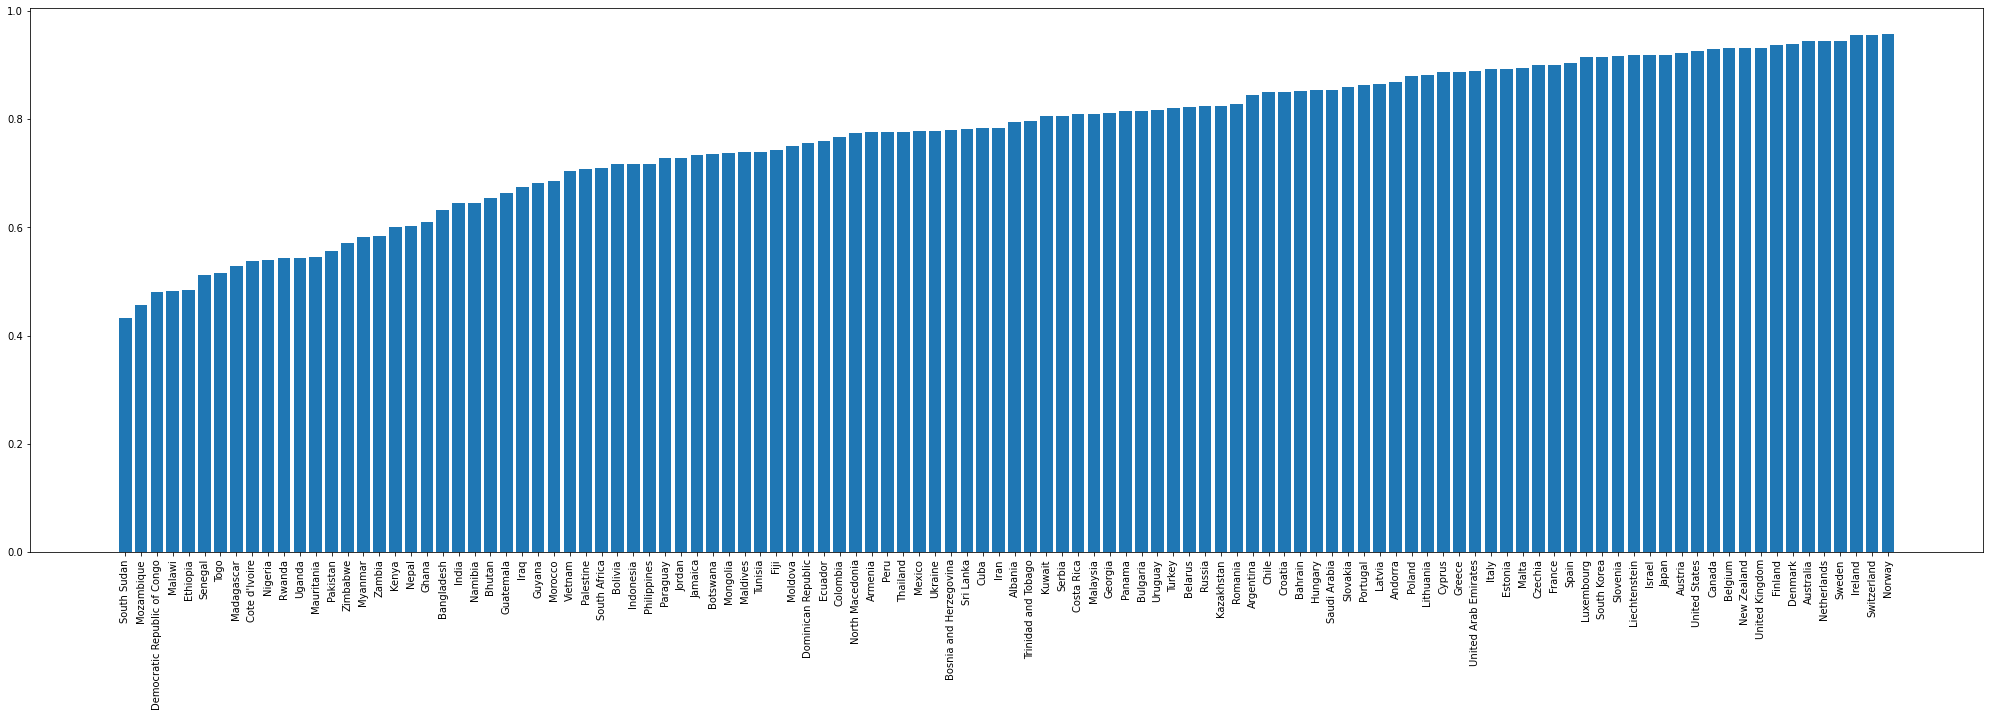

In [74]:
data_hdi = sorted(data, key = lambda x: x[1])
c_hdi = [data_hdi[i][0] for i in range(len(data_hdi))]
hs = [data_hdi[i][1] for i in range(len(data_hdi))]

print('Ραβδόγραμμα του μέσου human_development_index για την κάθε χώρα:')
fig = plt.figure(figsize=(35, 10))
plt.bar(c_hdi, hs)
plt.xticks(rotation=90)
plt.show()

Ραβδόγραμμα του μέσου ρυθμού θετικότητας για την κάθε χώρα:


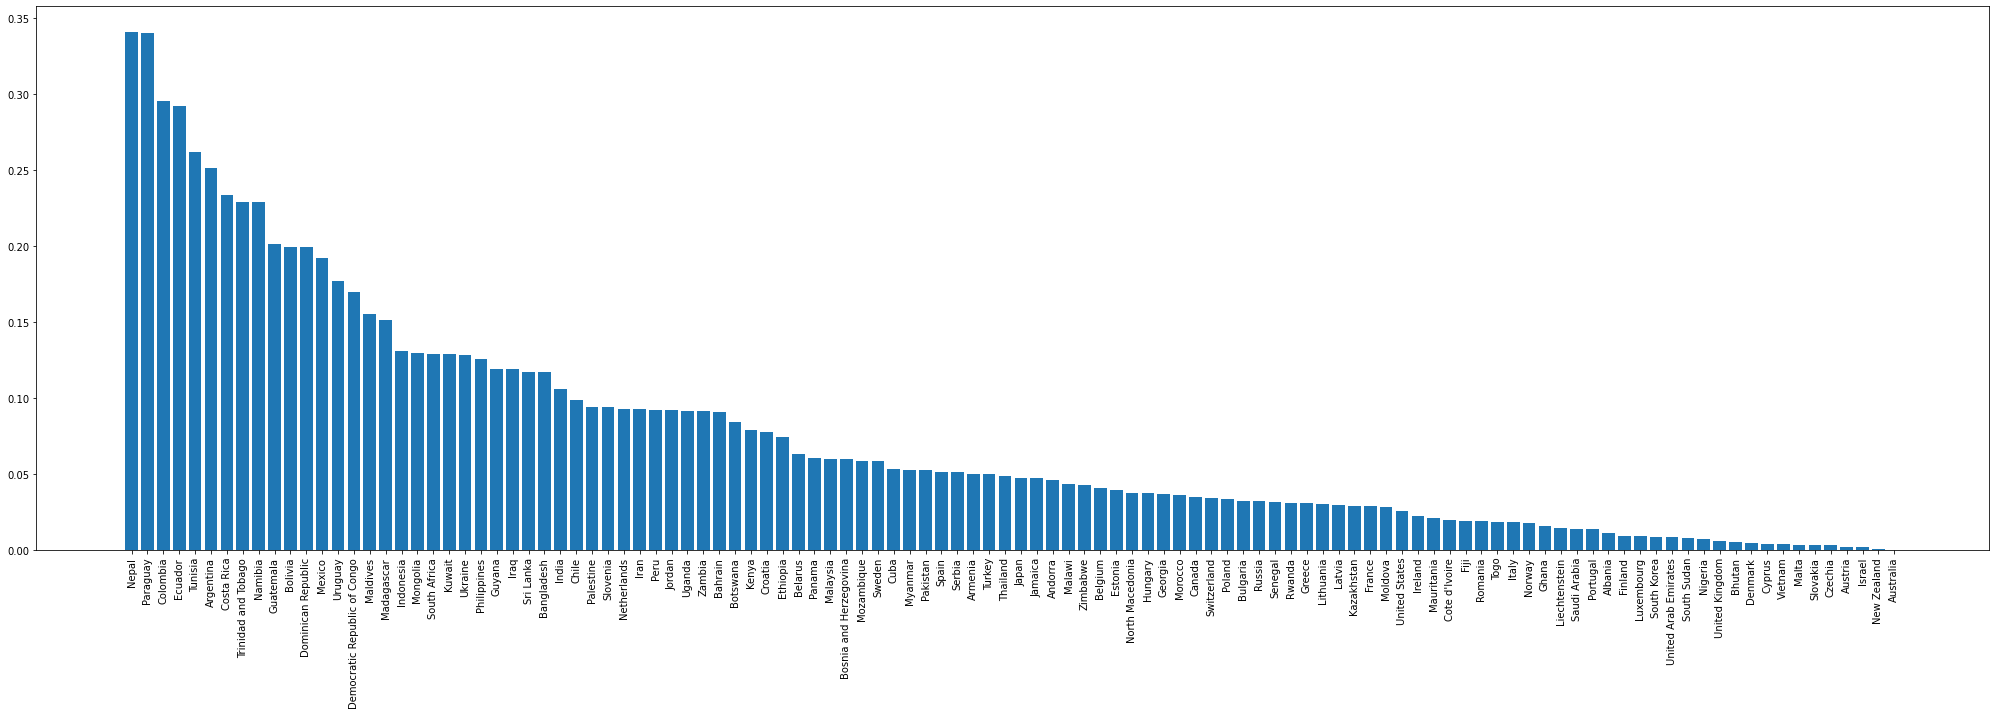

In [75]:
data_pr = sorted(data, key = lambda x: x[2], reverse=True)
c_pr = [data_pr[i][0] for i in range(len(data_pr))]
prses = [data_pr[i][2] for i in range(len(data_pr))]


print('Ραβδόγραμμα του μέσου ρυθμού θετικότητας για την κάθε χώρα:')
fig = plt.figure(figsize=(35, 10))
plt.bar((c_pr), prses)
plt.xticks(rotation=90)
plt.show()

Από τα παραπάνω δύο διαγράμματα παρατηρούμε ότι πράγματι πολλές χώρες με υψηλό δείκτη ανθρώπινης ανάπτυξης (>0.8) έχουν μικρό μέσο ρυθμό θετικότητας. Για παράδειγμα η Αυστραλία, η Νέα Ζηλανδία, το Ισραήλ, η Αυστρία και η Τσεχία είναι οι 5 χώρες με τον μικρότερο μέσο ρυθμό θετικότητας. Όλες αυτές οι χώρες έχουν δείκτη ανθρώπινης ανάπτυξης μεγαλύτερο από 0.8. Αντιθέτως, για παράδειγμα, το Νεπάλ, η Παραγουάη και η Κολομβία είναι οι 3 χώρες με τον μεγαλύτερο μέσο ρυθμό θετικότητας, οι οποίες ταυτόχρονα έχουν δείκτη ανθρώπινης ανάπτυξης μικρότερο από 0.8 (το Νεπάλ έχει περίπου 0.6). Γενικά παρατηρείται ότι ένας μικρός δείκτης ανθρώπινης ανάπτυξης συνεπάγεται έναν μεγαλύτερο μέσο ρυθμό θετικότητας. Αυτό μπορεί να δικαιολογηθεί από το γεγονός ότι ο δείκτης ανθρώπινης ανάπτυξης συνδέεται με την ποιότητα ζωής και διαβίωσης της κάθε χώρας. Ένας μικρός δείκτης σημαίνει ενδεχομένως κακή ποιότητα ζωής και δυσμενείς συνθήκες διαβίωσης. Σε τέτοιες χώρες προφανώς λοιμώδη νοσήματα όπως ο κορωνοϊός έχουν μεγαλύτερη πιθανότητα να εξαπλωθούν στον μαζικό πληθυσμό.